In [1]:
from utils_v1 import *


In [2]:
from icecream import ic
import pdb
from sklearn import metrics
import importlib
import utils_v1
import pathlib
import cv2
import sys
import numpy as np
from src import metrics as _metrics
from src.dataset import (
    MultipleDates,
    Para, ParaDeforestationTime, ParaDistanceMap, ParaMultipleDates,
    MTDeforestationTime, MTMultipleDates
)
from src import training_generator as generator
from src.patchesHandler import PatchesHandler, PatchesHandlerMultipleDates


In [3]:
# dataset = ParaDeforestationTime()
addPastDeforestationInput = True

# dataset = ParaMultipleDates(dates = [2018, 2019], # dates = [2017, 2018, 2019]. [2018, 2019]. [2015, 2016, 2017, 2018]
# 	addPastDeforestationInput = addPastDeforestationInput,
# 	borderBuffer = 2)	
dataset = MTMultipleDates(dates = [2019, 2020], # dates = [2016,2017,2018,2019]
	addPastDeforestationInput = addPastDeforestationInput,
	borderBuffer = 2)	
# dataset = MTDeforestationTime()	
# [2016, 2017, 2018]
# dataset = Para()
if issubclass(type(dataset), MultipleDates):
	patchesHandler = PatchesHandlerMultipleDates(
		dataset)
else:
	patchesHandler = PatchesHandler()

inference_times = 10

training = True
save_probabilities = True
loadInference = False
if training == False:
	if type(dataset) == Para:
		exp = 2

	if type(dataset) == ParaDeforestationTime:
		# exp = 3 # uses past deforestation mask until 2020, which is a mistake. use it until 2018
		exp = 4 # uses past deforestation mask without dates.
		exp = 5 # uses past deforestation mask with dates. 38 epochs.
		exp = 5 # fixes mask.
		exp = 6 # uses past deforestation distance and past deforestation. didnt test it yet        
		exp = 8 # Uses fixed past deforestation distance and past deforestation. 98.9 mAP
		exp = 9 # dummy for coords. high mAP. 99.8.   
		exp = 10 # using fixed fixed past deforestation distance. mAP 90.7   
		exp = 12 # Multiple dates. using fixed fixed past deforestation distance. mAP reduced to 89.6
	if type(dataset) == ParaDistanceMap:
		exp = 7 # not so good result.
	if type(dataset) == ParaMultipleDates:
		exp = 11 # Multiple dates. using fixed fixed past deforestation distance
		exp = 22
		exp = 50
		exp = 52
		# exp = 54
		exp = 56
		exp = 58
		# exp = 63
		# exp = 52
		# exp = 64
		# exp = 66
		exp = 66
		exp = 68
		
		# =============
		# exp = 72 # train 2015-2018
		# exp = 69 # train 2016-2018
		# exp = 70 # train 2017-2018
		
		# train 2018-2019. test 2018-2019
		# exp = 39 # old 
		exp = 76 # 88.4 mAP
		# exp = 71 # 89.5 mAP

		# =============
		
		### exp = 73
		# exp = 71
		# exp = 61

		exp = 77 # good?
		# exp = 78 # good but too short?
	if type(dataset) == MTDeforestationTime:
		exp = 28
	if type(dataset) == MTMultipleDates:
		exp = 73 # train 2018-2019
		# exp = 74 # train 2016-2019
		# exp = 75 # train 2017-2019
		

else:
	# exp = 13 # Multiple dates. using fixed fixed past deforestation distance
	exp = 78

ic| list(self.date_ids): [0]
ic| self.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]
ic| self.input_image_shape: 21
ic| self.dataset.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]


In [4]:
exp

77

In [5]:
figures_path = 'figures' + dataset.__class__.__name__ + '/'
pathlib.Path(figures_path).mkdir(parents=True, exist_ok=True)
title_name = 'ResUnet'

In [6]:
# ic(type(dataset), exp, dataset.dates)


In [7]:
# Loading reference
label_mask = dataset.loadLabel()
print('Mask label shape: ', '\n', label_mask.shape, '\n', 'Unique values: ', '\n', np.unique(label_mask))

D:/Jorge/datasets/deforestation/Para/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299508,
                                                                      2477969,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2018) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299508,
                                                                      2477969,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299508,
                                                                      2477969,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([0, 1], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299508,
                                                                      2477969,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| self.paths.labelFromProject: 'D:/Jorge/datasets/deforestation/Para_2018_2019/mask_label_17730x9203.npy'
ic| label_per_date.shape: (17730, 9203, 1)


Mask label shape:  
 (17730, 9203, 1) 
 Unique values:  
 [0 1 2]


In [8]:
# np.save('label_not_independent.npy', label_mask)


In [9]:
# Creating tile mask

mask_tiles = create_mask(label_mask.shape[0], label_mask.shape[1], 
        grid_size=(dataset.grid_x, dataset.grid_y))
label_mask = label_mask[:mask_tiles.shape[0], :mask_tiles.shape[1]]

Tiles size:  3546 2300
Mask size:  (17730, 9200)


In [10]:
label_mask.dtype

dtype('uint8')

In [11]:
label_mask_current_deforestation = dataset.getLabelCurrentDeforestation(
        label_mask)

In [12]:
label_mask.dtype

dtype('uint8')

In [13]:
# Loading image stack
image_stack = dataset.loadInputImage()

print('Image shape: ', image_stack.shape)
channels = image_stack.shape[-1]
image_stack = image_stack[:mask_tiles.shape[0], :mask_tiles.shape[1],:]
print('mask: ',mask_tiles.shape)
print('image stack: ', image_stack.shape)
print('ref :', label_mask.shape)
#plt.imshow(mask_tiles)

ic| image_stack.shape: (17730, 9203, 21)


Image shape:  (17730, 9203, 21)
mask:  (17730, 9200)
image stack:  (17730, 9200, 21)
ref : (17730, 9200, 1)


In [14]:
np.unique(image_stack[...,0], return_counts=True)

(array([0.        , 0.08333334, 0.16666667, 0.25      , 0.33333334,
        0.4166667 , 0.5       , 0.5833334 , 0.6666667 , 0.75      ,
        0.8333334 , 0.9166667 , 1.        ], dtype=float32),
 array([104050616,   2209014,    644713,    968315,   1458862,   1560879,
          2477424,   1299508,    903419,    864429,   4570932,   3150455,
         38957434], dtype=int64))

(-0.5, 9199.5, 17729.5, -0.5)

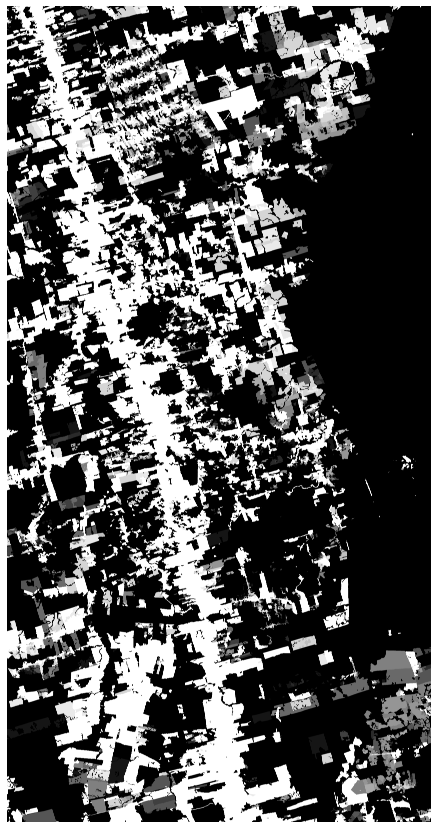

In [15]:


plt.figure(figsize=(15,15))
plt.imshow(image_stack[...,0], cmap=plt.cm.gray)

# title_name = 'ResUnet'
plt.axis('off')
# plt.savefig('figures/Para' + title_name + ' error mask.png', dpi=150, bbox_inches='tight')

In [16]:
ic(image_stack.shape)
channels = image_stack.shape[-1]
ic(channels)

ic| image_stack.shape: (17730, 9200, 21)
ic| channels: 21


21

In [17]:
mask_tr_val, mask_amazon_ts = dataset.getTrainValTestMasks(mask_tiles)


Training tiles:  [1, 3, 5, 8, 11, 13, 14, 20]
Validation tiles:  [6, 19]
Test tiles:  [2, 4, 7, 9, 10, 12, 15, 16, 17, 18]


In [18]:

patch_size = 128
if training == True:

    # Extracting patches from the idx matrix
    overlap = 0.7
    batch_size = 32
    im_idx = patchesHandler.create_idx_image(label_mask)


In [19]:
import importlib
if training == True:
	coords = patchesHandler.extract_patches(
		im_idx, patch_size=(patch_size, patch_size, 2), 
		overlap=overlap)

	coords_train, coords_val = patchesHandler.trainTestSplit(coords,
		mask_tr_val, patch_size=(patch_size, patch_size, 2))

	ic(coords_train.shape, coords_val.shape)
	# del im_idx

In [20]:
label_mask.shape

(17730, 9200, 1)

(-0.5, 9199.5, 17729.5, -0.5)

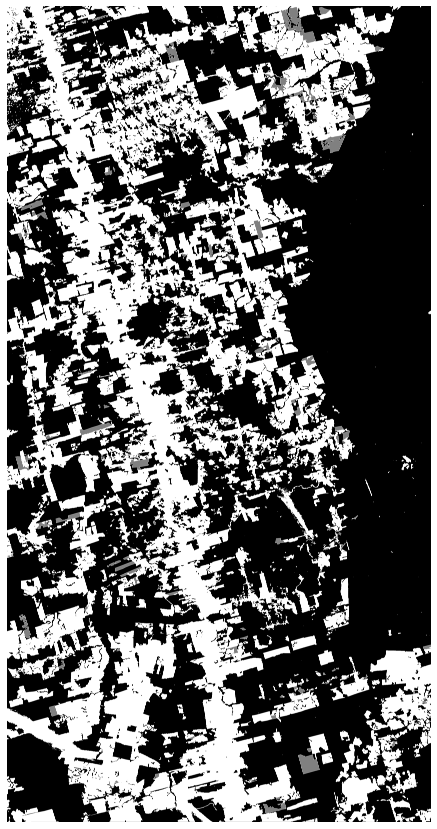

In [21]:

plt.figure(figsize=(15,15))
if type(dataset) != ParaDeforestationTime and type(dataset) != MTDeforestationTime:
    plt.imshow(label_mask[...,-1], cmap=plt.cm.gray)
else:
    plt.imshow(label_mask, cmap=plt.cm.gray)

# title_name = 'ResUnet'
plt.axis('off')
# plt.savefig('figures/Para' + title_name + ' error mask.png', dpi=150, bbox_inches='tight')

In [22]:
np.unique(label_mask)

array([0, 1, 2], dtype=uint8)

In [23]:
if training == True:
    print(coords_train)

In [24]:
if training == True:

    # Keeping patches with 2% of def class
    coords_train = patchesHandler.retrieve_idx_percentage(label_mask, coords_train, 
			patch_size, pertentage = 0.2)
    coords_val = patchesHandler.retrieve_idx_percentage(label_mask, coords_val, 
			patch_size, pertentage = 0.2)
    print('training samples: ', coords_train.shape, 
			'validation samples: ', coords_val.shape)


In [25]:
'''
import src.patchesHandler as sp
importlib.reload(sp)

patchesHandler = sp.PatchesHandlerMultipleDates(
		dataset)
'''

'\nimport src.patchesHandler as sp\nimportlib.reload(sp)\n\npatchesHandler = sp.PatchesHandlerMultipleDates(\n\t\tdataset)\n'

In [26]:
import src.plot as _plt
importlib.reload(_plt)

<module 'src.plot' from 'd:\\Jorge\\deforestation_uncertainty\\src\\plot.py'>

In [27]:
'''
if training == True:
    idx = 3100
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[4,5,6]]), np.mean(image_patch[...,[14,15,16]]))
    _plt.plotCropSample5(image_stack[...,[4,5,6]], image_stack[...,[14,15,16]], 
            image_stack[...,[24,25,26]], image_stack[...,[34,35,36]],
            image_stack[...,[44,45,46]],            
            lims = None, 
            titles = ['2015', '2016', '2017', '2018', '2019'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False, False],
            invertMask = [False, False, False, False, False])
'''

"\nif training == True:\n    idx = 3100\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[4,5,6]]), np.mean(image_patch[...,[14,15,16]]))\n    _plt.plotCropSample5(image_stack[...,[4,5,6]], image_stack[...,[14,15,16]], \n            image_stack[...,[24,25,26]], image_stack[...,[34,35,36]],\n            image_stack[...,[44,45,46]],            \n            lims = None, \n            titles = ['2015', '2016', '2017', '2018', '2019'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False, False],\n            invertMask = [False, False, False, False, False])\n"

In [28]:
inputSnipShow = False

In [29]:
if training == True and inputSnipShow == True:
    idx = 2800
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [30]:
'''
if training == True:

    idx = 6000
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])
'''

"\nif training == True:\n\n    idx = 6000\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))\n    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], \n            reference_patch, reference_patch,\n            lims = None, \n            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False],\n            invertMask = [False, False, False, False])\n"

In [31]:
if training == True and inputSnipShow == True:

    idx = 97
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [32]:
if training == True and inputSnipShow == True:

    idx = 1200
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [33]:
if training == True and inputSnipShow == True:

    idx = 400
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [34]:
'''
if training == True:

    idx = 6000
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])
'''

"\nif training == True:\n\n    idx = 6000\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))\n    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], \n            reference_patch, reference_patch,\n            lims = None, \n            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False],\n            invertMask = [False, False, False, False])\n"

In [35]:
# Creating train and validation data generator
# importlib.reload(patchesHandler)
import pdb
if training == True:

	train_datagen = ImageDataGenerator()
	valid_datagen = ImageDataGenerator()
	# pdb.set_trace()
	len_X_train = coords_train.shape[0]
	len_X_valid = coords_val.shape[0]

	train_gen = train_datagen.flow(
			np.expand_dims(np.expand_dims(coords_train, axis = -1), axis = -1), 
			np.expand_dims(np.expand_dims(coords_train, axis = -1), axis = -1),
			batch_size=batch_size,
			shuffle=True)
	# pdb.set_trace()

	valid_gen = valid_datagen.flow(
			np.expand_dims(np.expand_dims(coords_val, axis = -1), axis = -1), 
			np.expand_dims(np.expand_dims(coords_val, axis = -1), axis = -1),
			batch_size=batch_size,
			shuffle=False)

	number_class = 3
	train_gen_batch = patchesHandler.batch_generator(train_gen,
			image_stack, label_mask, patch_size, number_class)
	valid_gen_batch = patchesHandler.batch_generator(valid_gen,
			image_stack, label_mask, patch_size, number_class)

	#del image_stack

In [36]:
# Creating folder for the experiment

path_exp = dataset.paths.experiment + 'exp' + str(exp)
path_models = path_exp+'/models'
path_maps = path_exp+'/pred_maps'

if not os.path.exists(path_exp):
    os.makedirs(path_exp)   
if not os.path.exists(path_models):
    os.makedirs(path_models)   
if not os.path.exists(path_maps):
    os.makedirs(path_maps)
    
times = 1
method = 'resunet'
nb_filters = [16, 32, 64, 128, 256]
weights = [0.1, 0.9, 0]

In [37]:
if type(patchesHandler) == PatchesHandlerMultipleDates:
	channels = patchesHandler.input_image_shape

In [38]:
path_exp

'D:/Jorge/datasets/deforestation/experiments/exp77'

In [39]:
channels

21

In [40]:
image_stack.shape

(17730, 9200, 21)

In [41]:

metrics_all = []
if training == True:
    for tm in range(0,times):
        print('time: ', tm)

        rows = patch_size
        cols = patch_size
        adam = Adam(lr = 1e-3 , beta_1=0.9)
        
        loss = weighted_categorical_crossentropy(weights)
        input_shape = (rows, cols, channels)
        model = build_resunet_dropout_spatial(input_shape, nb_filters, number_class)
        
        model.compile(optimizer=adam, loss=loss, metrics=['accuracy'])
        model.summary()

        earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min')
        checkpoint = ModelCheckpoint(path_models+ '/' + method +'_'+str(tm)+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        lr_reduce = ReduceLROnPlateau(factor=0.9, min_delta=0.0001, patience=5, verbose=1)
        callbacks_list = [earlystop, checkpoint]
        # train the model
        start_training = time.time()
        history = model.fit_generator(train_gen_batch,
                                steps_per_epoch=len_X_train*3//train_gen.batch_size,
                                validation_data=valid_gen_batch,
                                validation_steps=len_X_valid*3//valid_gen.batch_size,
                                epochs=100,
                                callbacks=callbacks_list)
        end_training = time.time() - start_training
        # metrics_all.append(end_training)
        del model, history

    # Saving training time
    # np.save(path_exp+'/metrics_tr.npy', metrics_all)
    del train_gen_batch, valid_gen_batch

In [42]:
image_stack.shape

(17730, 9200, 21)

In [43]:
if type(dataset) != ParaDeforestationTime and type(dataset) != MTDeforestationTime:
    patchesHandler.dataset.image_channels[-1]

In [44]:
if type(dataset) == ParaMultipleDates:
	channels = patchesHandler.input_image_shape
	image_stack = image_stack[..., patchesHandler.dataset.image_channels[-1]]
	label_mask = label_mask[...,-1]

In [45]:
image_stack.shape

(17730, 9200, 21)

In [46]:
#%% Test loop

metrics_ts = []
n_pool = 3
n_rows = 5
n_cols = 4
rows, cols = image_stack.shape[:2]
pad_rows = rows - np.ceil(rows/(n_rows*2**n_pool))*n_rows*2**n_pool
pad_cols = cols - np.ceil(cols/(n_cols*2**n_pool))*n_cols*2**n_pool
print(pad_rows, pad_cols)

npad = ((0, int(abs(pad_rows))), (0, int(abs(pad_cols))), (0, 0))
image1_pad = np.pad(image_stack, pad_width=npad, mode='reflect')
# del image_stack


-30.0 -16.0


In [47]:

h, w, c = image1_pad.shape
c = channels
patch_size_rows = h//n_rows
patch_size_cols = w//n_cols
num_patches_x = int(h/patch_size_rows)
num_patches_y = int(w/patch_size_cols)

ic(path_models+ '/' + method +'_'+str(0)+'.h5')
model = load_model(path_models+ '/' + method +'_'+str(0)+'.h5', compile=False)
class_n = 3

if loadInference == False:
    if save_probabilities == False:
        # prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], class_n, inference_times), dtype = np.float32)
        prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], inference_times), dtype = np.float32)

    new_model = utils_v1.build_resunet_dropout_spatial(input_shape=(patch_size_rows,patch_size_cols, c), 
        nb_filters = nb_filters, n_classes = class_n, dropout_seed = None)

    for l in range(1, len(model.layers)):
        new_model.layers[l].set_weights(model.layers[l].get_weights())
    
            

    metrics_all =[]
    with tf.device('/cpu:0'):
        for tm in range(0,inference_times):
            print('time: ', tm)

            
            # Recinstructing predicted map
            start_test = time.time()
            '''
            args_network = {'patch_size_rows': patch_size_rows,
                'patch_size_cols': patch_size_cols,
                'c': c,
                'nb_filters': nb_filters,
                'class_n': class_n,
                'dropout_seed': inference_times}
            '''
            prob_reconstructed = patchesHandler.infer(
                    new_model, image1_pad, h, w, 
                    # model, image1_pad, h, w, 
                    num_patches_x, num_patches_y, patch_size_rows, 
                    patch_size_cols)
                    # patch_size_cols, a = args_network)
                    
            ts_time =  time.time() - start_test

            if save_probabilities == True:
                np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_reconstructed) 
            else:
                prob_rec[:,:,tm] = prob_reconstructed
            
            metrics_all.append(ts_time)
            del prob_reconstructed
        metrics_ = np.asarray(metrics_all)
        # Saving test time
        np.save(path_exp+'/metrics_ts.npy', metrics_)


ic| path_models+ '/' + method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/exp77/models/resunet_0.h5'


In [48]:
'''
with tf.device('/cpu:0'):
    for tm in range(0,times):
        np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_rec[:,:,tm]) 
'''

"\nwith tf.device('/cpu:0'):\n    for tm in range(0,times):\n        np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_rec[:,:,tm]) \n"

In [49]:
del image1_pad


In [76]:
# if loadInference == True:
if save_probabilities == True:
    prob_rec = np.zeros((h, w, inference_times), dtype = np.float32)

    for tm in range (0, inference_times):
        print(tm)
        prob_rec[:,:,tm] = np.load(path_maps+'/'+'prob_'+str(tm)+'.npy').astype(np.float32)




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


(50, 17760, 9216, 1)

In [259]:
useLessInferenceRuns = False
if useLessInferenceRuns == True:

    reducedInferenceRuns = 3
    # prob_rec_all = prob_rec.copy()
    prob_rec = prob_rec_all[:reducedInferenceRuns]
    prob_rec = np.transpose(np.squeeze(prob_rec), (1, 2, 0))


In [260]:
prob_rec.shape

(17760, 9216, 3)

In [261]:
prob_rec.shape

(17760, 9216, 3)

In [262]:
mean_prob = np.mean(prob_rec, axis = -1)
# np.save(path_maps+'/prob_mean.npy', mean_prob)


In [263]:
ic(np.min(mean_prob), np.mean(mean_prob), np.max(mean_prob))

ic| np.min(mean_prob): 6.776779e-33
    np.mean(mean_prob): 0.012865393
    np.max(mean_prob): 0.99999744


(6.776779e-33, 0.012865393, 0.99999744)

In [264]:
ic(mean_prob.shape)

ic| mean_prob.shape: (17760, 9216)


(17760, 9216)

In [265]:
# Computing metrics over the test tiles
mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
'''
ref1 = np.ones_like(label_mask).astype(np.float32)

ref1 [label_mask == 2] = 0
TileMask = mask_amazon_ts * ref1
GTTruePositives = label_mask==1
'''


'\nref1 = np.ones_like(label_mask).astype(np.float32)\n\nref1 [label_mask == 2] = 0\nTileMask = mask_amazon_ts * ref1\nGTTruePositives = label_mask==1\n'

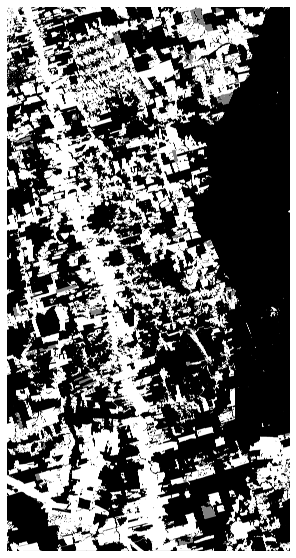

In [266]:
fig1 = plt.figure(figsize=(10,10))
plt.imshow(label_mask, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [267]:
if issubclass(type(dataset), MultipleDates):
    label_mask = np.squeeze(label_mask)

In [268]:
mean_prob.shape

(17730, 9200)

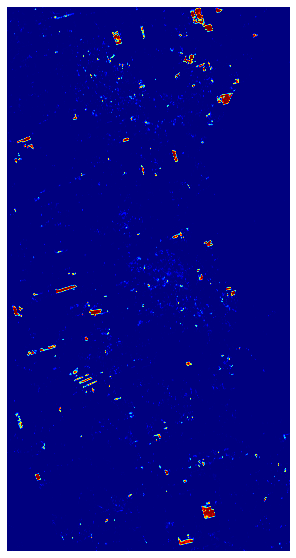

In [269]:
mean_prob = mean_prob.copy()
mean_prob[label_mask == 2] = 0
fig1 = plt.figure(figsize=(10,10))
plt.imshow(mean_prob, cmap = 'jet')
plt.axis('off')
plt.savefig('figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [270]:
# print(np.unique(label_mask, return_counts=True))
print(label_mask.shape)

(17730, 9200)


In [271]:
label_test = label_mask[mask_amazon_ts == 1]
mean_prob_test = mean_prob[mask_amazon_ts == 1]
mean_prob_test = mean_prob_test[label_test != 2]
label_test = label_test[label_test != 2]

print(label_test.shape)
print(np.unique(label_test, return_counts=True))

(54169125,)
(array([0, 1], dtype=uint8), array([53434933,   734192], dtype=int64))


In [272]:
from sklearn import metrics
mAP = round(metrics.average_precision_score(label_test, 
        mean_prob_test)*100, 2)
print(mAP)

91.06


In [273]:
from icecream import ic

ic(prob_rec.shape)
prob_rec = np.transpose(prob_rec, (2, 0, 1))


ic| prob_rec.shape: (17760, 9216, 3)


In [274]:
prob_rec = np.expand_dims(prob_rec, axis = -1)

In [275]:
ic(prob_rec.shape)

ic| prob_rec.shape: (3, 17760, 9216, 1)


(3, 17760, 9216, 1)

In [276]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

epsilon = 1e-15
def show_im(im, ax, title = "", cmap = "jet"):
    im_plt = ax.imshow(im.astype(np.float32), cmap = cmap)
    plt.title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im_plt, cax=cax) 

def get_mean(pred_probs):
      return np.mean(pred_probs, axis=0)
    
def get_uncertainty_var(pred_probs):
    return np.var(pred_probs, axis=0)
    
def predictive_variance(pred_probs):
    pred_var = get_uncertainty_var(pred_probs)
    pred_var = np.average(pred_var, axis = -1)
#    ic(pred_var.shape)
    return pred_var

def predictive_entropy(pred_probs):
    pred_mean = get_mean(pred_probs) # shape (patch_len, patch_len, class_n)
    pred_entropy = np.zeros((pred_mean.shape[0:2]))

    K = pred_mean.shape[-1]
    for k in range(K):
        pred_entropy = pred_entropy + pred_mean[..., k] * np.log(pred_mean[..., k] + epsilon) 
    pred_entropy = - pred_entropy / K
    return pred_entropy


def single_experiment_entropy(pred_prob):
    pred_entropy = np.zeros(pred_prob.shape[0:2])
    ic(pred_entropy.shape)
    
    K = pred_prob.shape[-1]
    for k in range(K):
        pred_entropy = pred_entropy + pred_prob[..., k] * np.log(pred_prob[..., k] + epsilon) 
    pred_entropy = - pred_entropy / K
    return pred_entropy

def mutual_information(pred_probs):
    H = predictive_entropy(pred_probs)
    sum_entropy = 0

    n = pred_probs.shape[0]
    K = pred_probs.shape[-1]
    ic(n, K)

    for i in range(n):
        for k in range(K):
            sum_entropy = sum_entropy + pred_probs[i, ..., k] * np.log(pred_probs[i, ..., k] + epsilon)

    sum_entropy = - sum_entropy / (n * K)

    MI = H - sum_entropy
    return MI

In [277]:
ic(np.min(prob_rec), np.mean(prob_rec), np.max(prob_rec))
ic(prob_rec.shape)

ic| np.min(prob_rec): 0.0
    np.mean(prob_rec): 0.012865362
    np.max(prob_rec): 1.0
ic| prob_rec.shape: (3, 17760, 9216, 1)


(3, 17760, 9216, 1)

In [278]:
pred_entropy = predictive_entropy(prob_rec).astype(np.float32)
pred_entropy_to_show = pred_entropy.copy()[:label_mask.shape[0], :label_mask.shape[1]]

pred_entropy_to_show[label_mask == 2] = 0



In [279]:
ic(np.min(pred_entropy_to_show), np.mean(pred_entropy_to_show), np.max(pred_entropy_to_show))
ic(np.min(pred_entropy), np.mean(pred_entropy), np.max(pred_entropy))
ic(pred_entropy.shape, pred_entropy_to_show.shape)

ic| np.min(pred_entropy_to_show): 0.0
    np.mean(pred_entropy_to_show): 0.007019908
    np.max(pred_entropy_to_show): 0.36787948
ic| np.min(pred_entropy): 2.3406166e-31
    np.mean(pred_entropy): 0.00807926
    np.max(pred_entropy): 0.36787948
ic| pred_entropy.shape: (17760, 9216)
    pred_entropy_to_show.shape: (17730, 9200)


((17760, 9216), (17730, 9200))

In [280]:
prob_rec.shape

(3, 17760, 9216, 1)

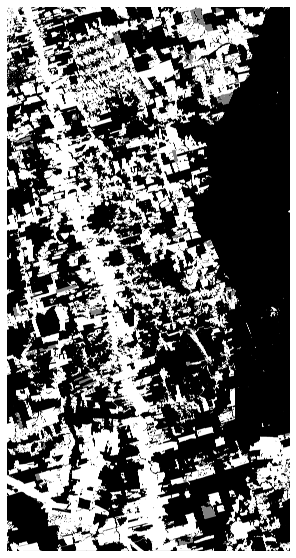

In [281]:
fig1 = plt.figure(figsize=(10,10))
plt.imshow(label_mask, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [282]:
# Computing error mask
# label_mask
'''
for idx in range(10):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(prob_rec[idx], cmap = 'jet')
# fig.savefig('figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')
'''

"\nfor idx in range(10):\n    fig, ax = plt.subplots(figsize=(10,10))\n    ax.set_xticks([])\n    ax.set_yticks([])\n    ax.imshow(prob_rec[idx], cmap = 'jet')\n# fig.savefig('figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')\n"

(-0.5, 9199.5, 17729.5, -0.5)

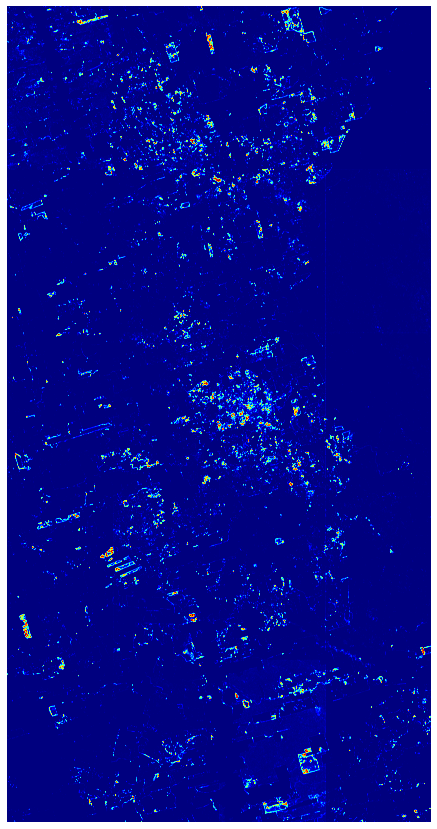

In [283]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(pred_entropy_to_show, cmap='jet')
# show_im(pred_entropy_to_show, ax, title = 'Uncertainty predictive entropy')
plt.axis('off')
#plt.savefig('figures/Para' + title_name + ' uncertainty predictive entropy.png', 
 #   dpi=150, bbox_inches='tight')

In [284]:
ic(pred_entropy.shape)


ic| pred_entropy.shape: (17760, 9216)


(17760, 9216)

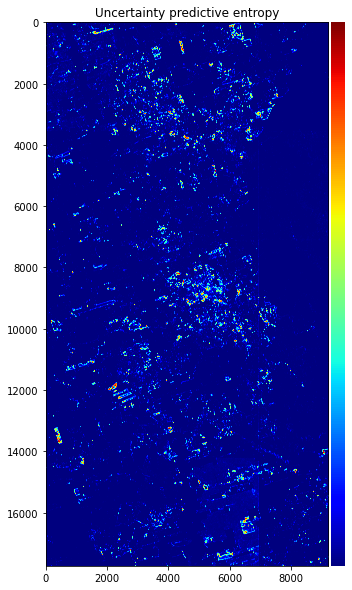

In [285]:

# pred_entropy_to_show = pred_entropy[:label_mask.shape[0], :label_mask.shape[1]].copy()

# ic(np.min(pred_entropy_to_show), np.mean(pred_entropy_to_show), np.max(pred_entropy_to_show))

# pred_entropy_to_show[label_mask == 2] = 0
fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_entropy_to_show, ax, title = 'Uncertainty predictive entropy')
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' uncertainty predictive entropy.png', 
    dpi=150, bbox_inches='tight')

In [286]:
ic(prob_rec.shape)
ic(np.min(prob_rec), np.mean(prob_rec), np.max(prob_rec))


ic| prob_rec.shape: (3, 17760, 9216, 1)
ic| np.min(prob_rec): 0.0
    np.mean(prob_rec): 0.012865362
    np.max(prob_rec): 1.0


(0.0, 0.012865362, 1.0)

In [287]:

pred_entropy_single = single_experiment_entropy(prob_rec[0])

'''
fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_entropy_single, ax, title = 'Uncertainty predictive entropy single sample')
'''


ic| pred_entropy.shape: (17760, 9216)


"\nfig, ax = plt.subplots(1,1,figsize=(10,10))\nshow_im(pred_entropy_single, ax, title = 'Uncertainty predictive entropy single sample')\n"

In [288]:

'''
MI = mutual_information(prob_rec)

fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(MI, ax, title = 'Uncertainty MI')
'''


"\nMI = mutual_information(prob_rec)\n\nfig, ax = plt.subplots(1,1,figsize=(10,10))\nshow_im(MI, ax, title = 'Uncertainty MI')\n"

(array([0, 1, 2], dtype=uint8), array([81558000, 65246400, 16311600], dtype=int64))


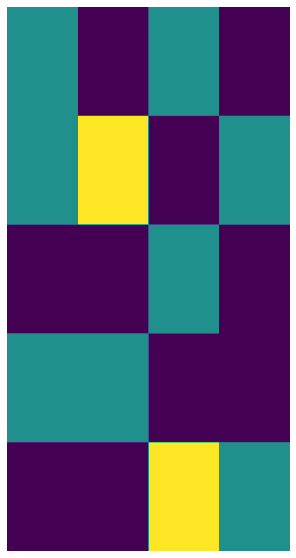

In [289]:
# mask_tr_val = test 0, train 1, val 2. 
# mask_ts = test 1.
print(np.unique(mask_tr_val, return_counts=True))
plt.figure(figsize=(10,10))
plt.imshow(mask_tr_val)
plt.axis('off')
plt.savefig('figures/Train val mask.png', dpi=200, bbox_inches='tight')



In [290]:
label_mask_current_deforestation = label_mask.copy()
label_mask_current_deforestation[label_mask_current_deforestation==2] = 0

In [291]:
label_mask_current_deforestation_to_show = label_mask_current_deforestation.copy()
label_mask_current_deforestation_to_show = np.abs(
        label_mask_current_deforestation_to_show - 1)
ic(np.unique(label_mask_current_deforestation_to_show, return_counts=True))

ic| np.unique(label_mask_current_deforestation_to_show, return_counts=True): (array([  0, 255], dtype=uint8), array([  1773593, 161342407], dtype=int64))


(array([  0, 255], dtype=uint8), array([  1773593, 161342407], dtype=int64))

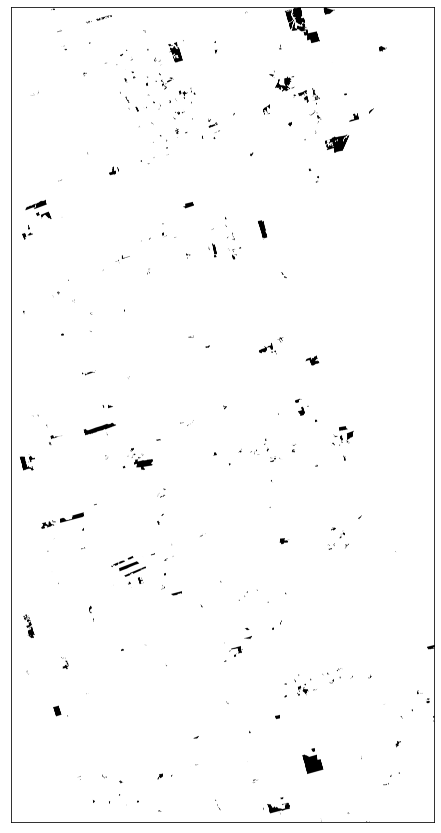

In [292]:
# Computing error mask
# label_mask

fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(label_mask_current_deforestation_to_show, cmap = plt.cm.gray)
fig.savefig('figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')




In [293]:


label_mask_val = label_mask[mask_tr_val == 2]
ic(label_mask_val.shape)

mean_prob_val = mean_prob[mask_tr_val == 2]

mean_prob_val = mean_prob_val[label_mask_val != 2]
label_mask_val_valid = label_mask_val[label_mask_val != 2]
ic(label_mask_val_valid.shape)



ic| label_mask_val.shape: (16311600,)
ic| label_mask_val_valid.shape: (9435626,)


(9435626,)

In [294]:
from sklearn import metrics
pos_label = 1
precision, recall, thresholds = metrics.precision_recall_curve(
            label_mask_val_valid, mean_prob_val, pos_label=pos_label)



In [295]:
fscore = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscore)
best_threshold = thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.464348, F-Score=0.872


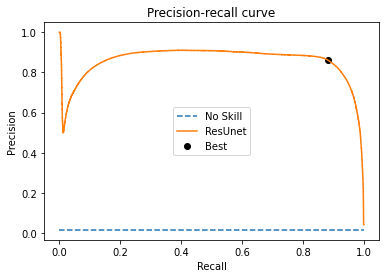

In [296]:
importlib.reload(_metrics)
_metrics.plotPrecisionRecall(label_mask_val, precision, recall, ix)
plt.savefig('figures/' + 'Para_prediction_recall_curve.png', dpi=150, bbox_inches='tight')

In [297]:
print(mean_prob.shape)
predicted = np.zeros_like(mean_prob)
threshold = 0.5

predicted[mean_prob>=threshold] = 1
predicted[mean_prob<threshold] = 0
# predicted[prob_rec[0][...,-1][:label_mask.shape[0], :label_mask.shape[1]]>=threshold] = 1
# predicted[prob_rec[0][...,-1][:label_mask.shape[0], :label_mask.shape[1]]<threshold] = 0

print(np.unique(predicted, return_counts=True))

predicted_unpad = predicted.copy()
predicted_unpad[label_mask == 2] = 0
ic(predicted_unpad.shape, predicted.shape)
del predicted

(17730, 9200)
(array([0., 1.], dtype=float32), array([161540562,   1575438], dtype=int64))


ic| predicted_unpad.shape: (17730, 9200)
    predicted.shape: (17730, 9200)


In [298]:
threshold

0.5

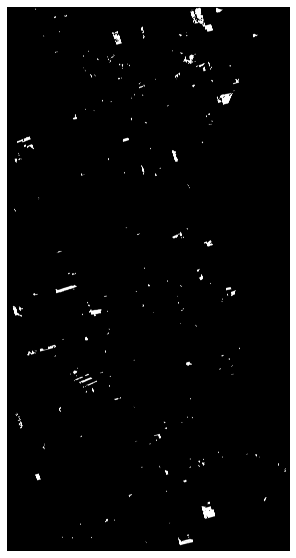

In [299]:

plt.figure(figsize=(10,10))
plt.imshow(predicted_unpad, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' predicted.png', dpi=150, bbox_inches='tight')


In [300]:

# mean_prob_unpad = mean_prob[:-npad[0][1], :-npad[1][1]]

In [301]:
# mean_prob_unpad.shape

In [302]:
# ic(mask_amazon_ts.shape)
# mask_amazon_ts = mask_amazon_ts[:-npad[0][1], :-npad[1][1]]


In [303]:
# ic(mask_amazon_ts.shape, predicted_unpad.shape)
# label_mask_current_deforestation = label_mask_current_deforestation[:-npad[0][1], :-npad[1][1]]

In [304]:
# label_mask = label_mask[:-npad[0][1], :-npad[1][1]]

In [305]:
import importlib
import utils_v1
importlib.reload(utils_v1)

<module 'utils_v1' from 'd:\\Jorge\\deforestation_uncertainty\\utils_v1.py'>

In [306]:
ic(predicted_unpad.shape, label_mask_current_deforestation.shape,
    mask_amazon_ts.shape, label_mask.shape, mean_prob.shape)

ic| predicted_unpad.shape: (17730, 9200)
    label_mask_current_deforestation.shape: (17730, 9200)
    mask_amazon_ts.shape: (17730, 9200)
    label_mask.shape: (17730, 9200)
    mean_prob.shape: (17730, 9200)


((17730, 9200), (17730, 9200), (17730, 9200), (17730, 9200), (17730, 9200))

In [307]:
# test metrics
from sklearn.metrics import f1_score

predicted_test = predicted_unpad[mask_amazon_ts == 1]
label_mask_current_deforestation_test = label_mask_current_deforestation[mask_amazon_ts == 1]
label_mask_test = label_mask[mask_amazon_ts == 1]
mean_prob_test = mean_prob[mask_amazon_ts == 1]

ic(predicted_test.shape)

predicted_test = utils_v1.excludeBackgroundAreasFromTest(
        predicted_test, label_mask_test)
label_mask_current_deforestation_test = utils_v1.excludeBackgroundAreasFromTest(
        label_mask_current_deforestation_test, label_mask_test)
mean_prob_test = utils_v1.excludeBackgroundAreasFromTest(
        mean_prob_test, label_mask_test)

ic(predicted_test.shape)


ic| predicted_test.shape: (81558000,)
ic| predicted_test.shape: (54169125,)


(54169125,)

In [308]:
importlib.reload(_metrics)
removePolygons = True
if removePolygons == True:
    # remove polygons smaller than 625 px
    min_polygon_area = 625 # pixels

    predicted_unpad, label_mask = _metrics.removeSmallPolygonsForMetrics(predicted_unpad, label_mask,
        min_polygon_area)
    predicted_masked, label_masked = _metrics.getTest(predicted_unpad, label_mask, mask_amazon_ts)

    predicted_test = predicted_masked
    label_mask_current_deforestation_test = label_masked


ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([161540562,   1575438], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([161540562,   1575438], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0.], dtype=float32), array([163116000], dtype=int64))
ic| predicted.shape: (17730, 9200), label_mask.shape: (17730, 9200)
ic| predicted_masked.shape: (81558000,)
    label_masked.shape: (81558000,)
ic| np.unique(label_masked, return_counts=True): (array([0, 1, 2], dtype=uint8),
                                                  array([53434933,   734192, 27388875], dtype=int64))
ic| predicted_masked.shape: (54169125,)
    label_masked.shape: (54169125,)


In [309]:

deforestationMetricsGet = True
if deforestationMetricsGet == True:
        f1 = round(f1_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        precision = round(precision_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        recall = round(recall_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        if removePolygons == False:
                mAP = round(metrics.average_precision_score(label_mask_current_deforestation_test, 
                        mean_prob_test)*100, 2)
        else:
                '''
                # Computing metrics over the test tiles
                # mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
                ref1 = np.ones_like(label_mask).astype(np.float32)

                ref1 [label_mask == 2] = 0
                TileMask = mask_amazon_ts * ref1
                GTTruePositives = label_mask==1

                # Metrics for th=0.5    

                Npoints = 50
                Pmax = np.max(mean_prob[GTTruePositives * TileMask ==1])
                ProbList = np.linspace(Pmax,0,Npoints)

                metrics_ = matrics_AA_recall(ProbList, mean_prob, label_mask, mask_amazon_ts, 625)
                print('Metrics th = 0.5: ', metrics_*100)
                '''
                pass


In [310]:
ic(f1, precision, recall)
# ic(f1, precision, recall)


ic| f1: 85.78, precision: 93.5, recall: 79.23


(85.78, 93.5, 79.23)

### Metrics for validation set in forest/deforestation detection

In [311]:
ic(mask_tr_val.shape)

ic| mask_tr_val.shape: (17730, 9200)


(17730, 9200)

In [312]:
predicted_val = predicted_unpad[mask_tr_val == 2]
predicted_val = predicted_val[label_mask_val != 2]

In [313]:

f1_val = round(f1_score(label_mask_val_valid, predicted_val)*100, 2)
precision_val = round(precision_score(label_mask_val_valid, predicted_val)*100, 2)
recall_val = round(recall_score(label_mask_val_valid, predicted_val)*100, 2)

mAP_val = round(metrics.average_precision_score(label_mask_val_valid, mean_prob_val)*100, 2)


ic(f1_val, precision_val, recall_val, mAP_val)

ic| f1_val: 87.07
    precision_val: 86.93
    recall_val: 87.21
    mAP_val: 85.45


(87.07, 86.93, 87.21, 85.45)

In [314]:
calculateMAPWithoutSmallPolygons = False
if calculateMAPWithoutSmallPolygons == True:
    # Computing metrics over the test tiles
    # mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
    ref1 = np.ones_like(label_mask).astype(np.uint8)

    ref1 [label_mask == 2] = 0
    TileMask = mask_amazon_ts * ref1
    GTTruePositives = label_mask==1

    # Metrics for th=0.5    

    ProbList_05 = [0.5]

    metrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)
    print('Metrics th = 0.5: ', metrics_05*100)


In [315]:

error_mask = np.abs(predicted_unpad - label_mask_current_deforestation)
print(np.unique(error_mask, return_counts=True))


(array([0., 1.], dtype=float32), array([162665273,    450727], dtype=int64))


In [316]:
false_positive_mask = predicted_unpad - label_mask_current_deforestation
ic(false_positive_mask.shape)
ic(np.unique(false_positive_mask, return_counts=True))
# 0 class 0, 1 class 1, 2 false positive, 3 false negative
# colormap black, white, blue, red.



ic| false_positive_mask.shape: (17730, 9200)
ic| np.unique(false_positive_mask, return_counts=True): (array([-1.,  0.,  1.], dtype=float32),
                                                         array([   324441, 162665273,    126286], dtype=int64))


(array([-1.,  0.,  1.], dtype=float32),
 array([   324441, 162665273,    126286], dtype=int64))

In [317]:
ic(predicted_unpad.shape, label_mask.shape)

ic| predicted_unpad.shape: (17730, 9200)
    label_mask.shape: (17730, 9200)


((17730, 9200), (17730, 9200))

In [318]:

importlib.reload(_metrics)

prediced_unpad_to_show = predicted_unpad.copy()
prediced_unpad_to_show[label_mask == 2] = 0

error_mask_to_show = _metrics.getRgbErrorMask(prediced_unpad_to_show, 
        label_mask_current_deforestation).astype(np.uint8)
error_mask_to_show_rgb = _metrics.saveRgbErrorMask(error_mask_to_show).astype(np.uint8)
del error_mask_to_show
cv2.imwrite('figures/Para_error_mask_to_show_rgb.png', error_mask_to_show_rgb)

# ,
#        dim = (617, 1162)


True

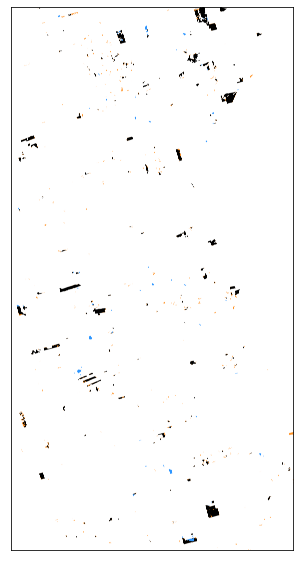

In [319]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xticks([])
ax.set_yticks([])

ax.imshow(error_mask_to_show_rgb[...,::-1])

fig.savefig('figures/Para' + title_name + ' error mask color.png', dpi=300, bbox_inches='tight')


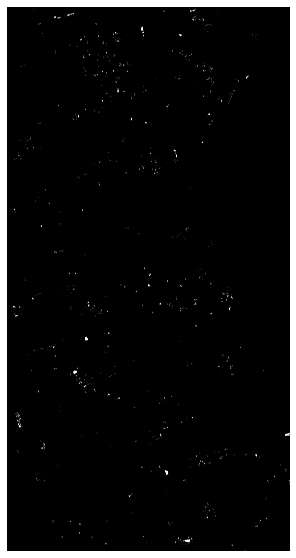

In [320]:
plt.figure(figsize=(10,10))
plt.imshow(error_mask, cmap=plt.cm.gray)
title_name = 'ResUnet'
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' error mask.png', dpi=150, bbox_inches='tight')

In [321]:
ic(label_mask.shape)
ic(mask_amazon_ts.shape)
 
label_mask_test = utils_v1.getTestVectorFromIm(
        label_mask, mask_amazon_ts)        
ic(label_mask_test.shape)

error_mask_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
        error_mask, mask_amazon_ts),
        label_mask_test) 


error_mask_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
        error_mask, mask_tr_val, mask_return_value = 2),
        label_mask_val) 

 
ic(error_mask_test.shape)

ic| label_mask.shape: (17730, 9200)
ic| mask_amazon_ts.shape: (17730, 9200)
ic| label_mask_test.shape: (81558000,)
ic| error_mask_test.shape: (54169125,)


(54169125,)

In [322]:
# ic(pred_entropy[:-npad[0][1], :-npad[1][1]][:-npad[0][1], :-npad[1][1]].shape)

In [323]:
     

ic(pred_entropy.shape, utils_v1.unpadIm(pred_entropy, npad).shape, 
    mask_amazon_ts.shape, label_mask_test.shape)
pred_entropy_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy, npad), mask_amazon_ts),
        label_mask_test)
  

ic| pred_entropy.shape: (17760, 9216)
    utils_v1.unpadIm(pred_entropy, npad).shape: (17730, 9200)
    mask_amazon_ts.shape: (17730, 9200)
    label_mask_test.shape: (81558000,)


In [324]:
pred_entropy_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)

In [325]:
pred_entropy_single_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy_single, npad), mask_amazon_ts),
        label_mask_test)

pred_entropy_single_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy_single, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)

In [326]:


# dataset.previewLims1 = np.array([7600, 8600, 4500, 5500])
# dataset.previewLims1 = np.array([12200, 13200, 200, 1200])
# dataset.previewLims1 = np.array([11800, 12800, 9000, 10000])

# dataset.previewLims1 = np.array([11500, 12500, 9000, 10000])

# dataset.previewLims2 = np.array([5000, 6000, 9500, 10500])

ic(dataset.previewLims1, dataset.previewLims2)
lims = dataset.previewLims1
ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True))
lims = dataset.previewLims2
ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]))
ic(mask_amazon_ts.shape)


ic| dataset.previewLims1: array([2200, 3200, 6900, 7900])
    dataset.previewLims2: array([ 500, 1500, 3500, 4500])
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| mask_amazon_ts.shape: (17730, 9200)


(17730, 9200)

ic| dataset.previewLims1: array([2200, 3200, 6900, 7900])
    dataset.previewLims2: array([ 500, 1500, 3500, 4500])
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


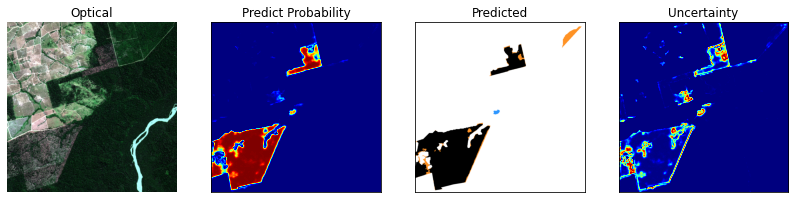

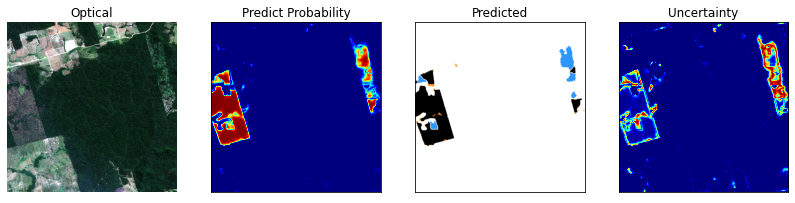

In [327]:


plotCropSampleFlag = True
if plotCropSampleFlag == True:
        importlib.reload(_metrics)
        # import matplotlib
        # customCmap = matplotlib.colors.ListedColormap(['black', 'red'])
        ic(dataset.previewLims1, dataset.previewLims2)
        lims = dataset.previewLims1
        ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]))
        lims = dataset.previewLims2
        ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True))

        _plt.plotCropSample4(image_stack[...,dataset.previewBands], mean_prob, 
                error_mask_to_show_rgb[...,::-1], pred_entropy_to_show, 
                lims = dataset.previewLims1, 
                titles = ['Optical', 'Predict Probability', 'Predicted', 'Uncertainty'],
                cmaps = [plt.cm.gray, 'jet', plt.cm.gray, 'jet'],
                maskBackground = [False, True, False, True],
                invertMask = [False, False, False, False])
        plt.savefig('figures/' + dataset.__class__.__name__ + 'PredictSampleUncertainty1.png', dpi=150, bbox_inches='tight')

        _plt.plotCropSample4(image_stack[...,dataset.previewBands], mean_prob, 
                error_mask_to_show_rgb[...,::-1], pred_entropy_to_show, 
                lims = dataset.previewLims2, 
                titles = ['Optical', 'Predict Probability', 'Predicted', 'Uncertainty'],
                cmaps = [plt.cm.gray, 'jet', plt.cm.gray, 'jet'],
                maskBackground = [False, True, False, True],
                invertMask = [False, False, False, False])
        plt.savefig('figures/' + dataset.__class__.__name__ + 'PredictSampleUncertainty2.png', dpi=150, bbox_inches='tight')

In [328]:
from enum import Enum
Predictor = Enum('Predictor', 'pred_var MI pred_entropy pred_entropy_single')
predictor = Predictor.pred_entropy
# predictor = Predictor.pred_var
# predictor = Predictor.pred_entropy_single
# predictor = Predictor.MI

if predictor == Predictor.pred_var:
    uncertainty = pred_var_test
    uncertainty_val = pred_var_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Variance'
    best_threshold = 0.2
elif predictor == Predictor.MI:
    uncertainty = MI_test
    uncertainty_val = MI_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Mutual Information'
    best_threshold = 0.2
elif predictor == Predictor.pred_entropy:
    uncertainty = pred_entropy_test
    uncertainty_val = pred_entropy_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Entropy'
    best_threshold = 0.287
elif predictor == Predictor.pred_entropy_single:
    uncertainty = pred_entropy_single_test
    uncertainty_val = pred_entropy_single_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Entropy Single'
    best_threshold = 0.287


In [329]:
ic(np.min(uncertainty), np.mean(uncertainty), np.max(uncertainty))
ic(np.min(pred_entropy), np.mean(pred_entropy), np.max(pred_entropy))


ic| np.min(uncertainty): 5.6405724e-20
    np.mean(uncertainty): 0.008590694
    np.max(uncertainty): 0.36787948
ic| np.min(pred_entropy): 2.3406166e-31
    np.mean(pred_entropy): 0.00807926
    np.max(pred_entropy): 0.36787948


(2.3406166e-31, 0.00807926, 0.36787948)

In [330]:

y_test = error_mask_test
y_val = error_mask_val

ic(y_test.shape, uncertainty.shape)
pos_label = 1
ROCmode = 'val'
if ROCmode == 'test':
    fpr, tpr, thresholds = metrics.roc_curve(y_test, uncertainty, pos_label=pos_label)
elif ROCmode == 'val':
    fpr, tpr, thresholds = metrics.roc_curve(y_val, uncertainty_val, pos_label=pos_label)

roc_auc = metrics.auc(fpr, tpr)
ic(roc_auc)

ic| y_test.shape: (54169125,), uncertainty.shape: (54169125,)
ic| roc_auc: 0.929647138847111


0.929647138847111

Best Threshold=0.022354, G-Mean=0.885


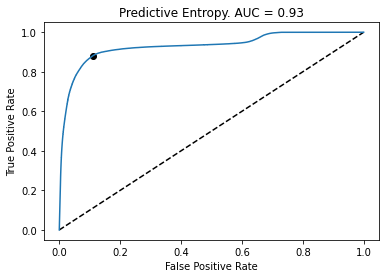

In [331]:
importlib.reload(_metrics)
plt.figure()
_metrics.plotAUC(fpr, tpr, roc_auc, modelId = title_name)
ix, best_threshold_uncertainty = _metrics.getBestThresholdGMean(fpr, tpr, thresholds)
# ix, best_threshold_uncertainty = _metrics.getBestThresholdJStatistic(fpr, tpr, thresholds)

_metrics.plotBestThreshold(fpr, tpr, ix)
plt.savefig(figures_path + title_name + ' roc_curve.png', dpi=200)

In [332]:
np.set_printoptions(suppress=False)
ic(best_threshold_uncertainty)
np.set_printoptions(suppress=True)


ic| best_threshold_uncertainty: 0.022353562


In [333]:
# best_threshold_uncertainty = 0.262948
# best_threshold_uncertainty = 0.08329400420188904

In [334]:
# threshold = 0.003254
y_pred_thresholded = np.zeros_like(uncertainty)
y_pred_thresholded[uncertainty >= best_threshold_uncertainty] = 1


In [335]:
metrics_error_detection = False
if metrics_error_detection == True:
    f1 = round(f1_score(error_mask_test, y_pred_thresholded)*100, 2)
    precision = round(metrics.precision_score(error_mask_test, y_pred_thresholded)*100, 2)
    recall = round(metrics.recall_score(error_mask_test, y_pred_thresholded)*100, 2)
    ic(f1, precision, recall)

    cm = metrics.confusion_matrix(error_mask_test, y_pred_thresholded)
    print(cm)

In [336]:
if metrics_error_detection == True:

    ic(best_threshold_uncertainty)

In [337]:
if metrics_error_detection == True:

    predicted_error_mask = np.zeros(pred_entropy.shape, dtype = np.uint8)
    predicted_error_mask[pred_entropy>=best_threshold_uncertainty] = 1
    predicted_error_mask = utils_v1.unpadIm(predicted_error_mask, npad)

    predicted_error_mask[label_mask == 2] = 0

In [338]:
if metrics_error_detection == True:

    # ic(np.unique(predicted_error_mask, return_counts=True))
    # ic(np.unique(error_mask, return_counts=True))
    predicted_error_mask_to_show = predicted_error_mask.copy()
    predicted_error_mask_to_show = np.abs(1 - predicted_error_mask_to_show)
    predicted_error_mask_to_show = predicted_error_mask_to_show.astype(np.uint8)*255
    predicted_error_mask_to_show = np.repeat(
        np.expand_dims(predicted_error_mask_to_show, axis=-1),
        3, axis = -1)
    fig, ax = plt.subplots(figsize=(15,15))
    ax.set_xticks([])
    ax.set_yticks([])

    ax.imshow(predicted_error_mask_to_show)


    title_name = 'ResUnet'
    fig.savefig('figures/Para' + title_name + 'predicted error mask.png', dpi=300, bbox_inches='tight')


In [339]:
if metrics_error_detection == True:

    predicted_error_mask_forest = predicted_error_mask.copy()
    predicted_error_mask_forest[predicted_unpad == 1] = 0
    ic(np.unique(predicted_unpad, return_counts=True))
    ic(np.unique(predicted_error_mask_forest, return_counts=True))

    plt.figure(figsize=(10,10))
    plt.imshow(predicted_error_mask, cmap=plt.cm.gray)
    title_name = 'ResUnet'
    plt.axis('off')
    plt.savefig('figures/Para' + title_name + 'predicted error mask forest.png', dpi=150, bbox_inches='tight')


In [340]:
if metrics_error_detection == True:

        importlib.reload(_metrics)
        _metrics.plotConfusionMatrix(cm)
        plt.savefig(figures_path + title_name + ' confusion matrix ROC threshold.png', 
                dpi=200, bbox_inches='tight')

In [341]:
label_mask_current_deforestation_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                label_mask_current_deforestation, mask_amazon_ts),
        label_mask_test)

predicted_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                predicted_unpad, mask_amazon_ts),
        label_mask_test)
        


Get precision-recall threshold

In [342]:
precision, recall, thresholds = metrics.precision_recall_curve(
            y_val, uncertainty_val, pos_label=pos_label)



In [343]:
ic(thresholds)

ic| thresholds: array([0.00014548, 0.00014548, 0.00014548, ..., 0.36787942, 0.36787945,
                       0.36787948], dtype=float32)


array([0.00014548, 0.00014548, 0.00014548, ..., 0.36787942, 0.36787945,
       0.36787948], dtype=float32)

In [344]:
fscore = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscore)
best_threshold_uncertainty = thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.310940, F-Score=0.322


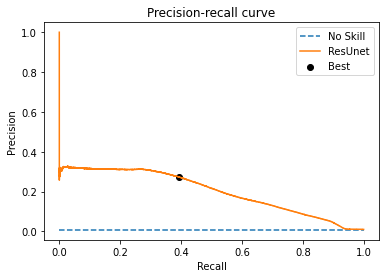

In [345]:
importlib.reload(_metrics)
_metrics.plotPrecisionRecall(y_val, precision, recall, ix)
plt.savefig('figures/' + 'Para' + 'prediction_recall_curve.png', dpi=150, bbox_inches='tight')

In [346]:
'''
# Metrics for th=0.5    
ProbList_05 = [0.5]

metrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)
print('Metrics th = 0.5: ', metrics_05*100)
'''


"\n# Metrics for th=0.5    \nProbList_05 = [0.5]\n\nmetrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)\nprint('Metrics th = 0.5: ', metrics_05*100)\n"

In [347]:
ic(np.min(uncertainty), np.average(uncertainty), np.max(uncertainty))

ic| np.min(uncertainty): 5.6405724e-20
    np.average(uncertainty): 0.008590694
    np.max(uncertainty): 0.36787948


(5.6405724e-20, 0.008590694, 0.36787948)

In [348]:
# plt.hist(uncertainty)

In [349]:
ic(uncertainty.dtype, label_mask_current_deforestation_test.dtype, predicted_test.dtype)

ic| uncertainty.dtype: dtype('float32')
    label_mask_current_deforestation_test.dtype: dtype('uint8')
    predicted_test.dtype: dtype('float32')


(dtype('float32'), dtype('uint8'), dtype('float32'))

In [350]:
ic(uncertainty.shape, label_mask_current_deforestation_test.shape)
ic(np.unique(label_mask_current_deforestation_test))

ic| uncertainty.shape: (54169125,)
    label_mask_current_deforestation_test.shape: (54169125,)
ic| np.unique(label_mask_current_deforestation_test): array([0, 1], dtype=uint8)


array([0, 1], dtype=uint8)

In [351]:
ic(np.min(uncertainty), np.mean(uncertainty), np.max(uncertainty))

ic| np.min(uncertainty): 5.6405724e-20
    np.mean(uncertainty): 0.008590694
    np.max(uncertainty): 0.36787948


(5.6405724e-20, 0.008590694, 0.36787948)

In [352]:
importlib.reload(_metrics)

threshold_uncertainty = 0.15

predicted_thresholded = np.zeros_like(uncertainty).astype(np.int8)
predicted_thresholded[uncertainty >= threshold_uncertainty] = 1
predicted_thresholded = predicted_thresholded.astype(np.uint8)
ic(predicted_thresholded.shape)


ic| predicted_thresholded.shape: (54169125,)


(54169125,)

In [353]:
ic(np.unique(predicted_thresholded, return_counts=True),
    np.unique(label_mask, return_counts=True),
    np.unique(mask_amazon_ts, return_counts=True))



ic| np.unique(predicted_thresholded, return_counts=True): (array([0, 1], dtype=uint8), array([53112969,  1056156], dtype=int64))
    np.unique(label_mask, return_counts=True): (array([0, 1, 2], dtype=uint8),
                                                array([100840413,   1773593,  60501994], dtype=int64))
    np.unique(mask_amazon_ts, return_counts=True): (array([0, 1], dtype=uint8), array([81558000, 81558000], dtype=int64))


((array([0, 1], dtype=uint8), array([53112969,  1056156], dtype=int64)),
 (array([0, 1, 2], dtype=uint8),
  array([100840413,   1773593,  60501994], dtype=int64)),
 (array([0, 1], dtype=uint8), array([81558000, 81558000], dtype=int64)))

In [354]:
def getUncertaintyPercentageFromTest(uncertainty_mask, 
        label_mask, mask_test):
    total_test_area = mask_test.copy()
    total_test_area[label_mask == 2] = 0

    percentage = np.count_nonzero(uncertainty_mask.flatten()) / np.count_nonzero(total_test_area.flatten())
    return total_test_area, percentage

total_test_area, percentage = getUncertaintyPercentageFromTest(predicted_thresholded, 
        label_mask, mask_amazon_ts)

ic(percentage)

ic| percentage: 0.019497379734304366


0.019497379734304366

In [355]:
AA = np.count_nonzero(predicted_thresholded.flatten()) / len(label_mask_current_deforestation_test)
ic(AA)

# metrics_values = _metrics.getAA_Recall(uncertainty, 
#                 label_mask_current_deforestation_test, 
#                 predicted_test, [threshold_uncertainty])


ic| AA: 0.019497379734304366


0.019497379734304366

In [356]:

importlib.reload(_metrics)

# threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]

# threshold_list = [0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003]
threshold_list = [0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
        0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003, np.max(uncertainty)-0.0015]

loadThresholdMetrics = False
if loadThresholdMetrics == False:
        # threshold_list = [0.1]
        # y_test
        ic(uncertainty.shape, label_mask_current_deforestation_test.shape)
        importlib.reload(_metrics)

        metrics_values = _metrics.getAA_Recall(uncertainty, 
                label_mask_current_deforestation_test, 
                predicted_test, threshold_list)

        # ic(metrics_values)


ic| uncertainty.shape: (54169125,)
    label_mask_current_deforestation_test.shape: (54169125,)


threshold 0.005
(48138616,) (48138616,)


ic| label_current_deforestation_test_classified_incorrect.shape: (6030509,)
    predicted_test_classified_incorrect.shape: (6030509,)


cm_correct [[47999382      849]
 [    9737   128648]]


ic| TP_H + FN_H + FP_H + TN_H: 6030509
    len(label_mask_current_deforestation_test): 54169125
ic| TP_H + FN_H + FP_H + TN_H: 6030509
    len(label_mask_current_deforestation_test): 54169125


cm_incorrect [[5395127   39575]
 [ 142726  453081]]
[0.99344386 0.92963833 0.17522392 0.11132742 0.91967011 0.76044927]
threshold 0.0075
(49020003,) (49020003,)


ic| label_current_deforestation_test_classified_incorrect.shape: (5149122,)
    predicted_test_classified_incorrect.shape: (5149122,)


cm_correct [[48844405      968]
 [   10953   163677]]


ic| TP_H + FN_H + FP_H + TN_H: 5149122
    len(label_mask_current_deforestation_test): 54169125
ic| TP_H + FN_H + FP_H + TN_H: 5149122
    len(label_mask_current_deforestation_test): 54169125


cm_incorrect [[4550104   39456]
 [ 141510  418052]]
[0.99412068 0.93727882 0.22293487 0.0950564  0.91375889 0.74710577]
threshold 0.01
(49587146,) (49587146,)


ic| label_current_deforestation_test_classified_incorrect.shape: (4581979,)
    predicted_test_classified_incorrect.shape: (4581979,)


cm_correct [[49382338     1056]
 [   12022   191730]]


ic| TP_H + FN_H + FP_H + TN_H: 4581979
    len(label_mask_current_deforestation_test): 54169125
ic| TP_H + FN_H + FP_H + TN_H: 4581979
    len(label_mask_current_deforestation_test): 54169125


cm_incorrect [[4012171   39368]
 [ 140441  389999]]
[0.99452242 0.9409969  0.26114422 0.08458654 0.90831154 0.73523678]
threshold 0.015
(50311354,) (50311354,)


ic| label_current_deforestation_test_classified_incorrect.shape: (3857771,)
    predicted_test_classified_incorrect.shape: (3857771,)


cm_correct [[50063383     1229]
 [   13919   232823]]


ic| TP_H + FN_H + FP_H + TN_H: 3857771
    len(label_mask_current_deforestation_test): 54169125
ic| TP_H + FN_H + FP_H + TN_H: 3857771
    len(label_mask_current_deforestation_test): 54169125


cm_incorrect [[3331126   39195]
 [ 138544  348906]]
[0.99474903 0.94358885 0.3171146  0.07121716 0.89900825 0.71577803]
threshold 0.025
(51099170,) (51099170,)


ic| label_current_deforestation_test_classified_incorrect.shape: (3069955,)
    predicted_test_classified_incorrect.shape: (3069955,)


cm_correct [[50803575     1803]
 [   16856   276936]]


ic| TP_H + FN_H + FP_H + TN_H: 3069955
    len(label_mask_current_deforestation_test): 54169125
ic| TP_H + FN_H + FP_H + TN_H: 3069955
    len(label_mask_current_deforestation_test): 54169125


cm_incorrect [[2590934   38621]
 [ 135607  304793]]
[0.99353158 0.94262608 0.37719834 0.05667352 0.88753807 0.6920822 ]
threshold 0.05
(51992494,) (51992494,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2176631,)
    predicted_test_classified_incorrect.shape: (2176631,)


cm_correct [[51627355     4294]
 [   22086   338759]]


ic| TP_H + FN_H + FP_H + TN_H: 2176631
    len(label_mask_current_deforestation_test): 54169125
ic| TP_H + FN_H + FP_H + TN_H: 2176631
    len(label_mask_current_deforestation_test): 54169125


cm_incorrect [[1767154   36130]
 [ 130377  242970]]
[0.98748298 0.93879366 0.46140383 0.04018213 0.87054819 0.65078868]
threshold 0.08
(52503787,) (52503787,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1665338,)
    predicted_test_classified_incorrect.shape: (1665338,)
ic

cm_correct [[52084420     7035]
 [   26766   385566]]
cm_incorrect [[1310089   33389]
 [ 125697  196163]]


| TP_H + FN_H + FP_H + TN_H: 1665338
    len(label_mask_current_deforestation_test): 54169125
ic| TP_H + FN_H + FP_H + TN_H: 1665338
    len(label_mask_current_deforestation_test): 54169125


[0.98208104 0.93508629 0.52515691 0.03074331 0.85454712 0.60946685]
threshold 0.1
(52726548,) (52726548,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1442577,)
    predicted_test_classified_incorrect.shape: (1442577,)
ic| TP_H + FN_H + FP_H + TN_H: 1442577


cm_correct [[52278931     8828]
 [   29565   409224]]
cm_incorrect [[1115578   31596]
 [ 122898  172505]]


    len(label_mask_current_deforestation_test): 54169125
ic| TP_H + FN_H + FP_H + TN_H: 1442577
    len(label_mask_current_deforestation_test): 54169125


[0.97888301 0.93262137 0.55738009 0.02663098 0.84519429 0.58396496]
threshold 0.15
(53112969,) (53112969,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1056156,)
    predicted_test_classified_incorrect.shape: (1056156,)
ic| TP_H + FN_H + FP_H + TN_H: 1056156
    len(label_mask_current_deforestation_test): 54169125
ic| TP_H + FN_H + FP_H + TN_H: 1056156
    len(label_mask_current_deforestation_test): 54169125


cm_correct [[52607718    13560]
 [   36513   455178]]
cm_incorrect [[786791  26864]
 [115950 126551]]
[0.97107126 0.92573995 0.61997134 0.01949738 0.82489326 0.52185764]
threshold 0.2
(53382133,) (53382133,)


ic| label_current_deforestation_test_classified_incorrect.shape: (786992,)
    predicted_test_classified_incorrect.shape: (786992,)
ic| TP_H + FN_H + FP_H + TN_H: 786992
    len(label_mask_current_deforestation_test): 54169125
ic| TP_H + FN_H + FP_H + TN_H: 786992
    len(label_mask_current_deforestation_test): 54169125


cm_correct [[52827536    18745]
 [   44373   491479]]
cm_incorrect [[566973  21679]
 [108090  90250]]
[0.96326123 0.91719169 0.66941481 0.01452842 0.80631472 0.45502672]
threshold 0.225
(53491682,) (53491682,)


ic| label_current_deforestation_test_classified_incorrect.shape: (677443,)
    predicted_test_classified_incorrect.shape: (677443,)
ic| TP_H + FN_H + FP_H + TN_H: 677443
    len(label_mask_current_deforestation_test): 54169125
ic| TP_H + FN_H + FP_H + TN_H: 677443
    len(label_mask_current_deforestation_test): 54169125


cm_correct [[52913949    21432]
 [   48703   507598]]
cm_incorrect [[480560  18992]
 [103760  74131]]
[0.95948812 0.91245207 0.69136956 0.01250607 0.79605468 0.41672148]
threshold 0.25
(53591878,) (53591878,)


ic| label_current_deforestation_test_classified_incorrect.shape: (577247,)
    predicted_test_classified_incorrect.shape: (577247,)
ic| TP_H + FN_H + FP_H + TN_H: 577247
    len(label_mask_current_deforestation_test): 54169125
ic| TP_H + FN_H + FP_H + TN_H: 577247
    len(label_mask_current_deforestation_test): 54169125


cm_correct [[52990812    24410]
 [   53652   523004]]
cm_incorrect [[403697  16014]
 [ 98811  58725]]
[0.95540852 0.90696013 0.71235317 0.01065638 0.78573436 0.37277194]
threshold 0.27
(53667839,) (53667839,)


ic| label_current_deforestation_test_classified_incorrect.shape: (501286,)
    predicted_test_classified_incorrect.shape: (501286,)
ic| TP_H + FN_H + FP_H + TN_H: 501286
    len(label_mask_current_deforestation_test): 54169125
ic| TP_H + FN_H + FP_H + TN_H: 501286
    len(label_mask_current_deforestation_test): 54169125


cm_correct [[53047408    26922]
 [   58451   535058]]
cm_incorrect [[347101  13502]
 [ 94012  46671]]
[0.95209438 0.90151624 0.72877122 0.00925409 0.77561365 0.33174584]
threshold 0.3
(53777417,) (53777417,)


ic| label_current_deforestation_test_classified_incorrect.shape: (391708,)
    predicted_test_classified_incorrect.shape: (391708,)
ic| TP_H + FN_H + FP_H + TN_H: 391708
    len(label_mask_current_deforestation_test): 54169125
ic| TP_H + FN_H + FP_H + TN_H: 391708
    len(label_mask_current_deforestation_test): 54169125


cm_correct [[53126034    31253]
 [   67227   552903]]
cm_incorrect [[268475   9171]
 [ 85236  28826]]
[0.94649888 0.89159209 0.75307685 0.0072312  0.75863884 0.2527222 ]
threshold 0.34
(53928052,) (53928052,)


ic| label_current_deforestation_test_classified_incorrect.shape: (241073,)
    predicted_test_classified_incorrect.shape: (241073,)
ic| TP_H + FN_H + FP_H + TN_H: 241073
    len(label_mask_current_deforestation_test): 54169125
ic| TP_H + FN_H + FP_H + TN_H: 241073
    len(label_mask_current_deforestation_test): 54169125


cm_correct [[53227733    38896]
 [   84031   577392]]
cm_incorrect [[166776   1528]
 [ 68432   4337]]
[0.93688665 0.87295422 0.78643189 0.00445038 0.73947144 0.05959955]
threshold 0.36
(54039445,) (54039445,)


ic| label_current_deforestation_test_classified_incorrect.shape: (129680,)
    predicted_test_classified_incorrect.shape: (129680,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:286: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 129680
    len(label_mask_current_deforestation_test): 54169125
ic| TP_H + FN_H + FP_H + TN_H: 129680
    len(label_mask_current_deforestation_test): 54169125


cm_correct [[53304429    40424]
 [  112863   581729]]
cm_incorrect [[90080     0]
 [39600     0]]
[0.93502563 0.83751181 0.79233906 0.00239398        nan 0.        ]
threshold 0.3648794801235199
(54089623,) (54089623,)


ic| label_current_deforestation_test_classified_incorrect.shape: (79502,)
    predicted_test_classified_incorrect.shape: (79502,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:286: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 79502
    len(label_mask_current_deforestation_test): 54169125
ic| TP_H + FN_H + FP_H + TN_H: 79502
    len(label_mask_current_deforestation_test): 54169125


cm_correct [[53339457    40424]
 [  128013   581729]]
cm_incorrect [[55052     0]
 [24450     0]]
[0.93502563 0.81963446 0.79233906 0.00146766        nan 0.        ]
threshold 0.3663794801235199
(54112855,) (54112855,)


ic| label_current_deforestation_test_classified_incorrect.shape: (56270,)
    predicted_test_classified_incorrect.shape: (56270,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:286: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 56270
    len(label_mask_current_deforestation_test): 54169125
ic| TP_H + FN_H + FP_H + TN_H: 56270
    len(label_mask_current_deforestation_test): 54169125


cm_correct [[53355581    40424]
 [  135121   581729]]
cm_incorrect [[38928     0]
 [17342     0]]
[0.93502563 0.81150729 0.79233906 0.00103878        nan 0.        ]


In [357]:

if loadThresholdMetrics == False:
        # threshold_list = [0.1]
        # y_test
        ic(uncertainty.shape, label_mask_current_deforestation_test.shape)
        importlib.reload(_metrics)

        metric_values_audited = _metrics.getUncertaintyMetricsAudited(uncertainty, 
                label_mask_current_deforestation_test, 
                predicted_test, threshold_list)

        ic(metric_values_audited)



ic| uncertainty.shape: (54169125,)
    label_mask_current_deforestation_test.shape: (54169125,)


threshold 0.005
(54169125,) (54169125,)
cm_audited [[53434084      849]
 [    9737   724455]]
[0.99882946 0.9867378 ]
threshold 0.0075
(54169125,) (54169125,)
cm_audited [[53433965      968]
 [   10953   723239]]
[0.99866337 0.98508156]
threshold 0.01
(54169125,) (54169125,)
cm_audited [[53433877     1056]
 [   12022   722170]]
[0.99853988 0.98362554]
threshold 0.015
(54169125,) (54169125,)
cm_audited [[53433704     1229]
 [   13919   720273]]
[0.99829661 0.98104174]
threshold 0.025
(54169125,) (54169125,)
cm_audited [[53433130     1803]
 [   16856   717336]]
[0.99749284 0.97704143]
threshold 0.05
(54169125,) (54169125,)
cm_audited [[53430639     4294]
 [   22086   712106]]
[0.99400614 0.96991795]
threshold 0.08
(54169125,) (54169125,)
cm_audited [[53427898     7035]
 [   26766   707426]]
[0.99015342 0.9635436 ]
threshold 0.1
(54169125,) (54169125,)
cm_audited [[53426105     8828]
 [   29565   704627]]
[0.98762641 0.95973124]
threshold 0.15
(54169125,) (54169125,)
cm_audited [[53421373

ic| metric_values_audited: array([[0.99882946, 0.9867378 ],
                                  [0.99866337, 0.98508156],
                                  [0.99853988, 0.98362554],
                                  [0.99829661, 0.98104174],
                                  [0.99749284, 0.97704143],
                                  [0.99400614, 0.96991795],
                                  [0.99015342, 0.9635436 ],
                                  [0.98762641, 0.95973124],
                                  [0.98093468, 0.95026778],
                                  [0.97354509, 0.93956213],
                                  [0.96968261, 0.93366449],
                                  [0.96537343, 0.92692375],
                                  [0.96168576, 0.92038731],
                                  [0.95523891, 0.90843403],
                                  [0.94355184, 0.88554629],
                                  [0.93891376, 0.84627591],
                                  [0.937

cm_audited [[53394509    40424]
 [  135121   599071]]
[0.93678762 0.81595959]


In [358]:
m_audited = {'precision': metric_values_audited[:,0],
        'recall': metric_values_audited[:,1]}



In [359]:
'''
threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34]
importlib.reload(_metrics)

metrics = _metrics.getF1byThreshold(uncertainty,
    error_mask, threshold_list)

ic(metrics)
'''

'\nthreshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34]\nimportlib.reload(_metrics)\n\nmetrics = _metrics.getF1byThreshold(uncertainty,\n    error_mask, threshold_list)\n\nic(metrics)\n'

In [360]:
if loadThresholdMetrics == False:

    np.save('metrics.npy', metrics_values)
if loadThresholdMetrics == True:
    metrics_values = np.load('metrics.npy')


In [361]:
save_figures = True

In [362]:
m = {'precision_L': metrics_values[:,0],
        'recall_L': metrics_values[:,1],
        'recall_Ltotal': metrics_values[:,2],
        'AA': metrics_values[:,3],
        'precision_H': metrics_values[:,4],
        'recall_H': metrics_values[:,5]}

m['f1_L'] = 2*m['precision_L']*m['recall_L']/(m['precision_L']+m['recall_L'])
m['f1_H'] = 2*m['precision_H']*m['recall_H']/(m['precision_H']+m['recall_H'])

m_audited['f1'] = 2*m_audited['precision']*m_audited['recall']/(m_audited['precision']+m_audited['recall'])

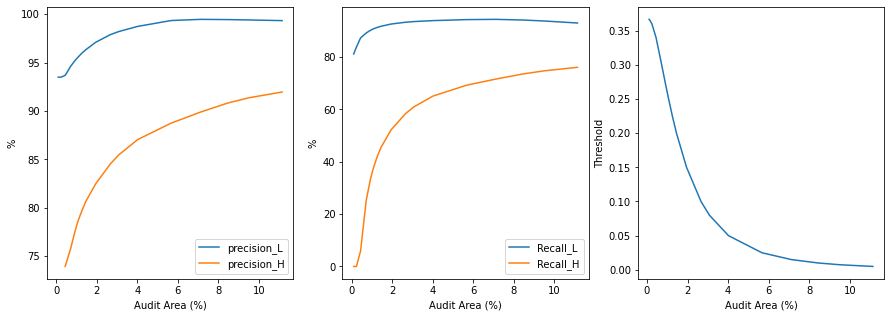

In [363]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m['AA']*100, m['precision_L']*100, label="precision_L")
ax1.plot(m['AA']*100, m['precision_H']*100, label="precision_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m['AA']*100, m['recall_L']*100, label="Recall_L")
ax2.plot(m['AA']*100, m['recall_H']*100, label="Recall_H")
ax2.legend(loc="lower right")
ax2.set_ylabel('%')
ax2.set_xlabel('Audit Area (%)')

ax3.plot(m['AA']*100, np.asarray(threshold_list), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_AA.png', dpi=150, bbox_inches='tight')

In [364]:
xlim = [-0.3, 12.7]
xlim = [-0.1, 10.4]

ylim = [0, 105]


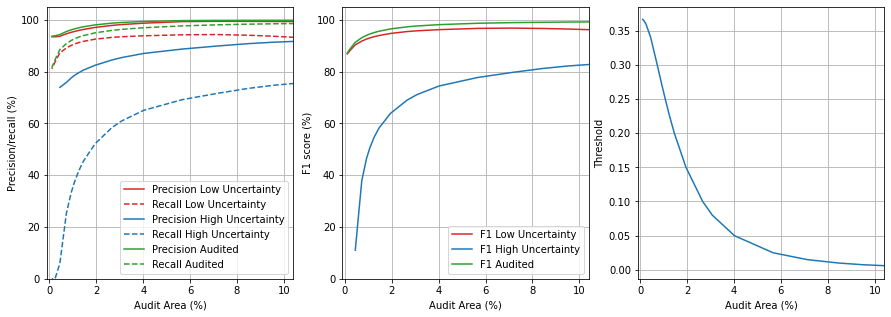

In [365]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m['AA']*100, m['precision_L']*100, 'C3-', label="Precision Low Uncertainty")
ax1.plot(m['AA']*100, m['recall_L']*100, 'C3--', label="Recall Low Uncertainty")
ax1.plot(m['AA']*100, m['precision_H']*100, 'C0-', label="Precision High Uncertainty")
ax1.plot(m['AA']*100, m['recall_H']*100, 'C0--', label="Recall High Uncertainty")
ax1.plot(m['AA']*100, m_audited['precision']*100, 'C2-', label="Precision Audited")
ax1.plot(m['AA']*100, m_audited['recall']*100, 'C2--', label="Recall Audited")

ax1.legend(loc="lower right")
ax1.set_ylabel('Precision/recall (%)')
ax1.set_xlabel('Audit Area (%)')
ax1.set_ylim(ylim)
ax1.set_xlim(xlim)
ax1.grid()
ax2.plot(m['AA']*100, m['f1_L']*100, 'C3-', label="F1 Low Uncertainty")
ax2.plot(m['AA']*100, m['f1_H']*100, 'C0-', label="F1 High Uncertainty")
ax2.plot(m['AA']*100, m_audited['f1']*100, 'C2-', label="F1 Audited")

ax2.legend(loc="lower right")
ax2.set_ylabel('F1 score (%)')
ax2.set_xlabel('Audit Area (%)')
ax2.set_ylim(ylim)
ax2.set_xlim(xlim)

ax2.grid()
ax3.plot(m['AA']*100, np.asarray(threshold_list), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')
ax3.grid()
ax3.set_xlim(xlim)

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_f1_AA.png', dpi=150, bbox_inches='tight')

In [366]:


m

{'precision_L': array([0.99344386, 0.99412068, 0.99452242, 0.99474903, 0.99353158,
        0.98748298, 0.98208104, 0.97888301, 0.97107126, 0.96326123,
        0.95948812, 0.95540852, 0.95209438, 0.94649888, 0.93688665,
        0.93502563, 0.93502563, 0.93502563]),
 'recall_L': array([0.92963833, 0.93727882, 0.9409969 , 0.94358885, 0.94262608,
        0.93879366, 0.93508629, 0.93262137, 0.92573995, 0.91719169,
        0.91245207, 0.90696013, 0.90151624, 0.89159209, 0.87295422,
        0.83751181, 0.81963446, 0.81150729]),
 'recall_Ltotal': array([0.17522392, 0.22293487, 0.26114422, 0.3171146 , 0.37719834,
        0.46140383, 0.52515691, 0.55738009, 0.61997134, 0.66941481,
        0.69136956, 0.71235317, 0.72877122, 0.75307685, 0.78643189,
        0.79233906, 0.79233906, 0.79233906]),
 'AA': array([0.11132742, 0.0950564 , 0.08458654, 0.07121716, 0.05667352,
        0.04018213, 0.03074331, 0.02663098, 0.01949738, 0.01452842,
        0.01250607, 0.01065638, 0.00925409, 0.0072312 , 0.004450

In [367]:
m_audited

{'precision': array([0.99882946, 0.99866337, 0.99853988, 0.99829661, 0.99749284,
        0.99400614, 0.99015342, 0.98762641, 0.98093468, 0.97354509,
        0.96968261, 0.96537343, 0.96168576, 0.95523891, 0.94355184,
        0.93891376, 0.9374825 , 0.93678762]),
 'recall': array([0.9867378 , 0.98508156, 0.98362554, 0.98104174, 0.97704143,
        0.96991795, 0.9635436 , 0.95973124, 0.95026778, 0.93956213,
        0.93366449, 0.92692375, 0.92038731, 0.90843403, 0.88554629,
        0.84627591, 0.82564098, 0.81595959]),
 'f1': array([0.99274681, 0.99182597, 0.9910266 , 0.98959397, 0.98716122,
        0.98181432, 0.97666729, 0.97347903, 0.96535774, 0.95625178,
        0.95133275, 0.94575796, 0.94058343, 0.93124873, 0.91362931,
        0.89019123, 0.87801448, 0.87220888])}

In [379]:

importlib.reload(_metrics)


# threshold_list = [0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
#         0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003, np.max(uncertainty)-0.0015]
#threshold_list2 = [0.09] # exp 77 PA 50 runs
# threshold_list2 = [0.085] # exp 77 PA 30 runs
# threshold_list2 = [0.085] # exp 77 PA 10 runs
# threshold_list2 = [0.083] # exp 77 PA 5 runs
threshold_list2 = [0.065] # exp 77 PA 5 runs
threshold_list2 = [0.06] # exp 77 PA 5 runs
threshold_list2 = [0.0825] # exp 77 PA 3 runs


ic(uncertainty.shape, label_mask_current_deforestation_test.shape)

metrics_values2 = _metrics.getAA_Recall(uncertainty, 
        label_mask_current_deforestation_test, 
        predicted_test, threshold_list2)

metric_values_audited2 = _metrics.getUncertaintyMetricsAudited(uncertainty, 
        label_mask_current_deforestation_test, 
        predicted_test, threshold_list2)



ic| uncertainty.shape: (54169125,)
    label_mask_current_deforestation_test.shape: (54169125,)


threshold 0.0825
(52535389,) (52535389,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1633736,)
    predicted_test_classified_incorrect.shape: (1633736,)
ic

cm_correct [[52112223     7262]
 [   27126   388778]]
cm_incorrect [[1282286   33162]
 [ 125337  192951]]


| TP_H + FN_H + FP_H + TN_H: 1633736
    len(label_mask_current_deforestation_test): 54169125
ic| TP_H + FN_H + FP_H + TN_H: 1633736
    len(label_mask_current_deforestation_test): 54169125


[0.98166347 0.93477822 0.52953178 0.03015991 0.85333882 0.60621513]
threshold 0.0825
(54169125,) (54169125,)
cm_audited [[53427671     7262]
 [   27126   707066]]
[0.9898338  0.96305326]


In [380]:
m2 = {'precision_L': metrics_values2[:,0],
        'recall_L': metrics_values2[:,1],
        'recall_Ltotal': metrics_values2[:,2],
        'AA': metrics_values2[:,3],
        'precision_H': metrics_values2[:,4],
        'recall_H': metrics_values2[:,5]}

m_audited2 = {'precision': metric_values_audited2[:,0],
        'recall': metric_values_audited2[:,1]}

m2['f1_L'] = 2*m2['precision_L']*m2['recall_L']/(m2['precision_L']+m2['recall_L'])
m2['f1_H'] = 2*m2['precision_H']*m2['recall_H']/(m2['precision_H']+m2['recall_H'])

m_audited2['f1'] = 2*m_audited2['precision']*m_audited2['recall']/(m_audited2['precision']+m_audited2['recall'])

ic(m2)
ic(m_audited2)


ic| m2: {'AA': array([0.03015991]),
         'f1_H': array([0.70885616]),
         'f1_L': array([0.95764733]),
         'precision_H': array([0.85333882]),
         'precision_L': array([0.98166347]),
         'recall_H': array([0.60621513]),
         'recall_L': array([0.93477822]),
         'recall_Ltotal': array([0.52953178])}
ic| m_audited2: {'f1': array([0.97625991]),
                 'precision': array([0.9898338]),
                 'recall': array([0.96305326])}


{'precision': array([0.9898338]),
 'recall': array([0.96305326]),
 'f1': array([0.97625991])}

In [370]:
pred_entropy_unpad = utils_v1.unpadIm(pred_entropy, npad)
ic(pred_entropy_unpad.shape)

threshold_uncertainty = 0.1

uncertainty_mask = np.zeros_like(pred_entropy_unpad).astype(np.int8)
uncertainty_mask[pred_entropy_unpad >= threshold_uncertainty] = 1
ic(np.unique(uncertainty_mask, return_counts=True))


ic| pred_entropy_unpad.shape: (17730, 9200)
ic| np.unique(uncertainty_mask, return_counts=True): (array([0, 1], dtype=int8), array([159080307,   4035693], dtype=int64))


(array([0, 1], dtype=int8), array([159080307,   4035693], dtype=int64))

In [371]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(pred_entropy, cmap='jet')
plt.axis('off')


(-0.5, 9215.5, 17759.5, -0.5)

Error in callback <function flush_figures at 0x000001D6FEBEC1F0> (for post_execute):


KeyboardInterrupt: 

(-0.5, 9199.5, 17729.5, -0.5)

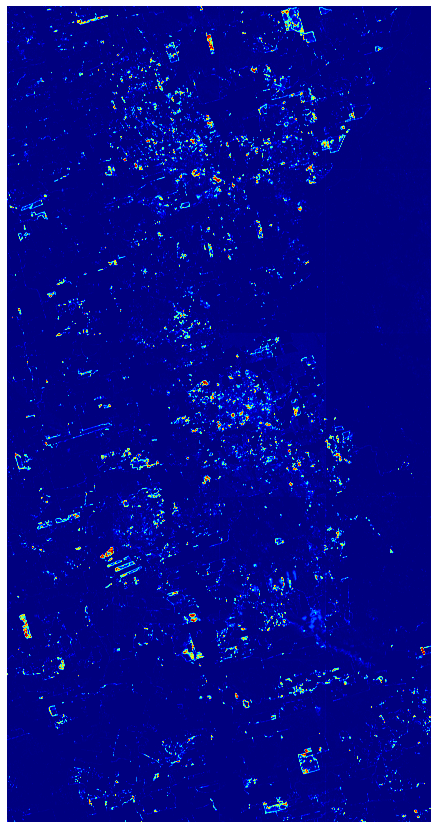

In [ ]:

fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(pred_entropy_to_show, cmap='jet')
plt.axis('off')


(-0.5, 9199.5, 17729.5, -0.5)

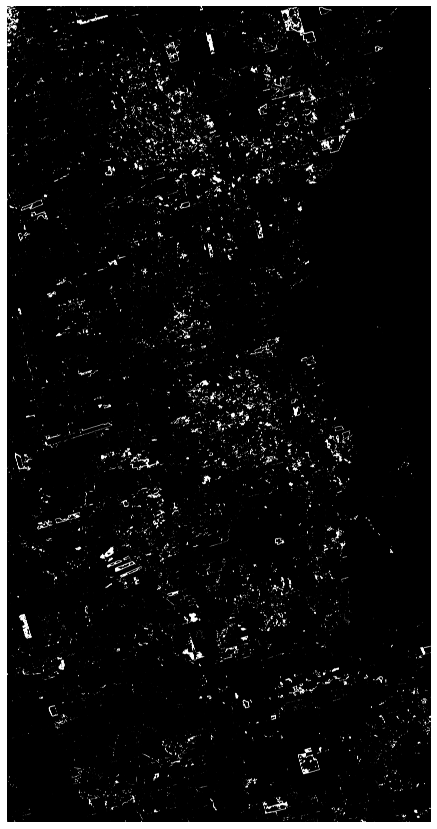

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(uncertainty_mask, cmap=plt.cm.gray)
plt.axis('off')


In [ ]:
np.unique(label_mask_val_valid, return_counts=True)

(array([0, 1], dtype=uint8), array([9182054,  271168], dtype=int64))

In [ ]:
importlib.reload(_metrics)

threshold_list_val = [0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]

loadThresholdMetrics = False
if loadThresholdMetrics == False:
        # threshold_list_val = [0.1]
        # y_test
        ic(uncertainty_val.shape, label_mask_val_valid.shape)
        importlib.reload(_metrics)

        metrics_values_val = _metrics.getAA_Recall(uncertainty_val, 
                label_mask_val_valid, 
                predicted_val, threshold_list_val)

        ic(metrics_values_val)



ic| uncertainty_val.shape: (9453222,)
    label_mask_val_valid.shape: (9453222,)


threshold 0.015
(8084328,) (8084328,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1368894,)
    predicted_test_classified_incorrect.shape: (1368894,)
ic| TP_H + FN_H + FP_H + TN_H: 1368894
    len(label_mask_current_deforestation_test): 9453222


cm_correct [[7997873    7088]
 [    287   79080]]
cm_incorrect [[1147174   29919]
 [  40311  151490]]


ic| TP_H + FN_H + FP_H + TN_H: 1368894
    len(label_mask_current_deforestation_test): 9453222


[0.91774209 0.99638389 0.29162733 0.14480714 0.83507433 0.78982904]
threshold 0.025
(8403401,) (8403401,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1049821,)
    predicted_test_classified_incorrect.shape: (1049821,)
ic| TP_H + FN_H + FP_H + TN_H: 1049821
    len(label_mask_current_deforestation_test): 9453222
ic| TP_H + FN_H + FP_H + TN_H: 1049821
    len(label_mask_current_deforestation_test): 9453222


cm_correct [[8292392    9047]
 [    465  101497]]
cm_incorrect [[852655  27960]
 [ 40133 129073]]
[0.91815928 0.99543948 0.37429564 0.11105431 0.82194825 0.76281574]
threshold 0.05
(8740487,) (8740487,)


ic| label_current_deforestation_test_classified_incorrect.shape: (712735,)
    predicted_test_classified_incorrect.shape: (712735,)
ic| TP_H + FN_H + FP_H + TN_H: 712735
    len(label_mask_current_deforestation_test): 9453222
ic| TP_H + FN_H + FP_H + TN_H: 712735
    len(label_mask_current_deforestation_test): 9453222


cm_correct [[8594904   12076]
 [    884  132623]]
cm_incorrect [[550143  24931]
 [ 39714  97947]]
[0.916544   0.99337862 0.48908057 0.07539599 0.7971077  0.71150871]
threshold 0.08
(8922637,) (8922637,)


ic| label_current_deforestation_test_classified_incorrect.shape: (530585,)
    predicted_test_classified_incorrect.shape: (530585,)
ic| TP_H + FN_H + FP_H + TN_H: 530585
    len(label_mask_current_deforestation_test): 9453222
ic| TP_H + FN_H + FP_H + TN_H: 530585
    len(label_mask_current_deforestation_test): 9453222


cm_correct [[8753198   14501]
 [   1583  153355]]
cm_incorrect [[391849  22506]
 [ 39015  77215]]
[0.91361048 0.98978301 0.56553502 0.05612742 0.77431033 0.66432935]
threshold 0.1
(8998773,) (8998773,)


ic| label_current_deforestation_test_classified_incorrect.shape: (454449,)
    predicted_test_classified_incorrect.shape: (454449,)
ic| TP_H + FN_H + FP_H + TN_H: 454449
    len(label_mask_current_deforestation_test): 9453222
ic| TP_H + FN_H + FP_H + TN_H: 454449
    len(label_mask_current_deforestation_test): 9453222


cm_correct [[8817506   15967]
 [   2233  163067]]
cm_incorrect [[327541  21040]
 [ 38365  67503]]
[0.91081582 0.98649123 0.60135045 0.04807345 0.76237534 0.63761477]
threshold 0.15
(9125913,) (9125913,)


ic| label_current_deforestation_test_classified_incorrect.shape: (327309,)
    predicted_test_classified_incorrect.shape: (327309,)
ic| TP_H + FN_H + FP_H + TN_H: 327309
    len(label_mask_current_deforestation_test): 9453222
ic| TP_H + FN_H + FP_H + TN_H: 327309
    len(label_mask_current_deforestation_test): 9453222


cm_correct [[8919584   19308]
 [   4648  182373]]
cm_incorrect [[225463  17699]
 [ 35950  48197]]
[0.90426466 0.97514718 0.67254617 0.03462407 0.7314101  0.57277146]
threshold 0.2
(9209849,) (9209849,)


ic| label_current_deforestation_test_classified_incorrect.shape: (243373,)
    predicted_test_classified_incorrect.shape: (243373,)
ic| TP_H + FN_H + FP_H + TN_H: 243373
    len(label_mask_current_deforestation_test): 9453222
ic| TP_H + FN_H + FP_H + TN_H: 243373
    len(label_mask_current_deforestation_test): 9453222


cm_correct [[8982768   22740]
 [   7113  197228]]
cm_incorrect [[162279  14267]
 [ 33485  33342]]
[0.89662133 0.96519054 0.72732771 0.02574498 0.70032977 0.49893007]
threshold 0.25
(9274540,) (9274540,)


ic| label_current_deforestation_test_classified_incorrect.shape: (178682,)
    predicted_test_classified_incorrect.shape: (178682,)
ic| TP_H + FN_H + FP_H + TN_H: 178682
    len(label_mask_current_deforestation_test): 9453222
ic| TP_H + FN_H + FP_H + TN_H: 178682
    len(label_mask_current_deforestation_test): 9453222


cm_correct [[9028698   26238]
 [  10163  209441]]
cm_incorrect [[116349  10769]
 [ 30435  21129]]
[0.88867061 0.95372124 0.77236621 0.0189017  0.66239263 0.40976263]
threshold 0.27
(9298107,) (9298107,)


ic| label_current_deforestation_test_classified_incorrect.shape: (155115,)
    predicted_test_classified_incorrect.shape: (155115,)
ic| TP_H + FN_H + FP_H + TN_H: 155115
    len(label_mask_current_deforestation_test): 9453222
ic| TP_H + FN_H + FP_H + TN_H: 155115
    len(label_mask_current_deforestation_test): 9453222


cm_correct [[9044262   28004]
 [  11704  214137]]
cm_incorrect [[100785   9003]
 [ 28894  16433]]
[0.88434838 0.94817593 0.78968389 0.01640869 0.64605284 0.3625433 ]
threshold 0.3
(9333375,) (9333375,)


ic| label_current_deforestation_test_classified_incorrect.shape: (119847,)
    predicted_test_classified_incorrect.shape: (119847,)
ic| TP_H + FN_H + FP_H + TN_H: 119847
    len(label_mask_current_deforestation_test): 9453222
ic| TP_H + FN_H + FP_H + TN_H: 119847
    len(label_mask_current_deforestation_test): 9453222


cm_correct [[9067117   31030]
 [  14484  220744]]
cm_incorrect [[77930  5977]
 [26114  9826]]
[0.87675455 0.9384257  0.81404886 0.0126779  0.62178067 0.27340011]
threshold 0.34
(9383188,) (9383188,)


ic| label_current_deforestation_test_classified_incorrect.shape: (70034,)
    predicted_test_classified_incorrect.shape: (70034,)
ic| TP_H + FN_H + FP_H + TN_H: 70034
    len(label_mask_current_deforestation_test): 9453222
ic| TP_H + FN_H + FP_H + TN_H: 70034
    len(label_mask_current_deforestation_test): 9453222


cm_correct [[9097726   36043]
 [  20229  229190]]
cm_incorrect [[47321   964]
 [20369  1380]]
[0.86410816 0.91889551 0.8451956  0.00740848 0.5887372  0.06345119]
threshold 0.36
(9417713,) (9417713,)


ic| label_current_deforestation_test_classified_incorrect.shape: (35509,)
    predicted_test_classified_incorrect.shape: (35509,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:286: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 35509
    len(label_mask_current_deforestation_test): 9453222
ic| TP_H + FN_H + FP_H + TN_H: 35509
    len(label_mask_current_deforestation_test): 9453222
ic| metrics_values_val: array([[0.91774209, 0.99638389, 0.29162733, 0.14480714, 0.83507433,
                                0.78982904],
                               [0.91815928, 0.99543948, 0.37429564, 0.11105431, 0.82194825,
                                0.76281574],
                               [0.916544  , 0.99337862, 0.48908057, 0.07539599, 0.7971077 ,
                                0.71150871],
                               [0.91361048, 0.98978301, 0.56553502, 0.05612742, 0.77431033,
                           

cm_correct [[9120754   37007]
 [  29382  230570]]
cm_incorrect [[24293     0]
 [11216     0]]
[0.86169589 0.88697144 0.85028469 0.00375629        nan 0.        ]


In [ ]:
m_val = {'precision_L': metrics_values_val[:,0],
        'recall_L': metrics_values_val[:,1],
        'recall_Ltotal': metrics_values_val[:,2],
        'AA': metrics_values_val[:,3],
        'precision_H': metrics_values_val[:,4],
        'recall_H': metrics_values_val[:,5]}


save_figures=False

In [ ]:
threshold_list_val = [0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]


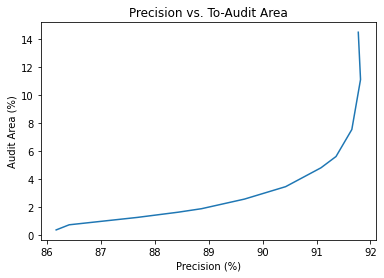

In [ ]:
plt.plot(m_val['precision_L']*100, m_val['AA']*100)
plt.title('Precision vs. To-Audit Area')
plt.xlabel('Precision (%)')
plt.ylabel('Audit Area (%)')
if True:
    plt.savefig('figures/precision_AA_val.png', dpi=150, bbox_inches='tight')

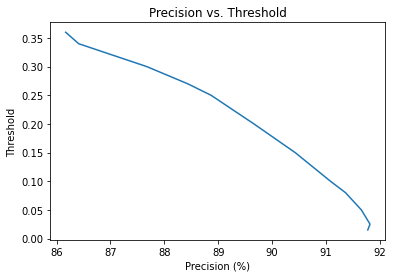

In [ ]:
plt.plot(m_val['precision_L']*100, np.asarray(threshold_list_val))
plt.title('Precision vs. Threshold')
plt.xlabel('Precision (%)')
plt.ylabel('Threshold')
if True:
    plt.savefig('figures/precision_total_threshold_val.png', dpi=150, bbox_inches='tight')

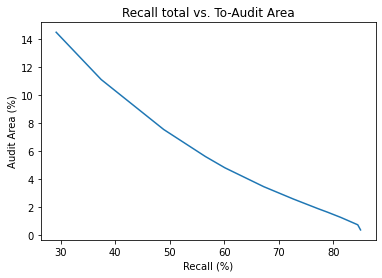

In [ ]:
plt.plot(m_val['recall_Ltotal']*100, m_val['AA']*100)
plt.title('Recall total vs. To-Audit Area')
plt.xlabel('Recall (%)')
plt.ylabel('Audit Area (%)')
if True:
    plt.savefig('figures/recall_total_AA_val.png', dpi=150, bbox_inches='tight')

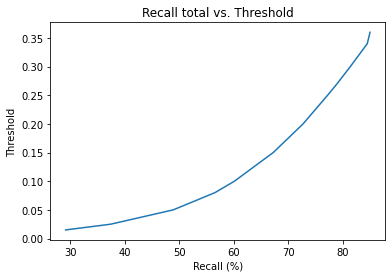

In [ ]:
plt.plot(m_val['recall_Ltotal']*100, np.asarray(threshold_list_val))
plt.title('Recall total vs. Threshold')
plt.xlabel('Recall (%)')
plt.ylabel('Threshold')
if True:
    plt.savefig('figures/recall_total_threshold_val.png', dpi=150, bbox_inches='tight')

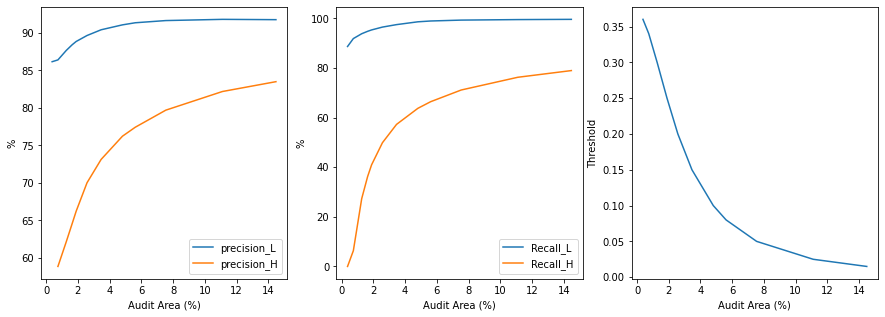

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m_val['AA']*100, m_val['precision_L']*100, label="precision_L")
ax1.plot(m_val['AA']*100, m_val['precision_H']*100, label="precision_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m_val['AA']*100, m_val['recall_L']*100, label="Recall_L")
ax2.plot(m_val['AA']*100, m_val['recall_H']*100, label="Recall_H")
ax2.legend(loc="lower right")
ax2.set_ylabel('%')
ax2.set_xlabel('Audit Area (%)')

ax3.plot(m_val['AA']*100, np.asarray(threshold_list_val), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_AA_val.png', dpi=150, bbox_inches='tight')

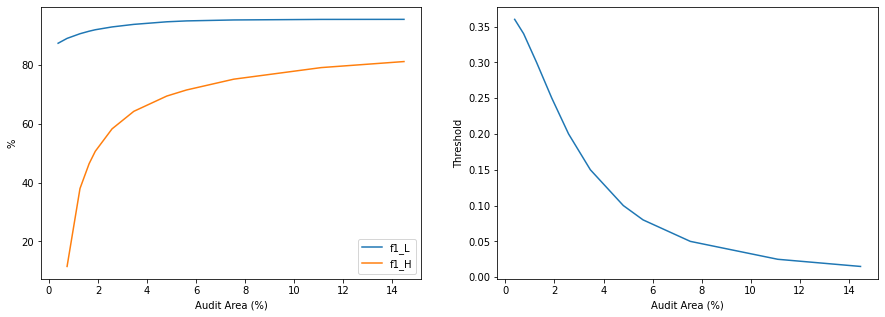

In [ ]:
m_val['f1_L'] = 2*m_val['precision_L']*m_val['recall_L']/(m_val['precision_L']+m_val['recall_L'])
m_val['f1_H'] = 2*m_val['precision_H']*m_val['recall_H']/(m_val['precision_H']+m_val['recall_H'])

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m_val['AA']*100, m_val['f1_L']*100, label="f1_L")
ax1.plot(m_val['AA']*100, m_val['f1_H']*100, label="f1_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m_val['AA']*100, np.asarray(threshold_list_val), label="AA")
ax2.set_xlabel('Audit Area (%)')
ax2.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/f1_AA_val.png', dpi=150, bbox_inches='tight')

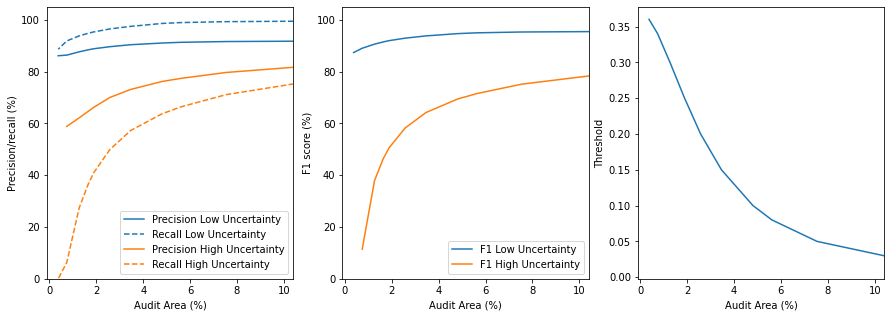

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m_val['AA']*100, m_val['precision_L']*100, 'C0-', label="Precision Low Uncertainty")
ax1.plot(m_val['AA']*100, m_val['recall_L']*100, 'C0--', label="Recall Low Uncertainty")
ax1.plot(m_val['AA']*100, m_val['precision_H']*100, 'C1-', label="Precision High Uncertainty")
ax1.plot(m_val['AA']*100, m_val['recall_H']*100, 'C1--', label="Recall High Uncertainty")
ax1.legend(loc="lower right")
ax1.set_ylabel('Precision/recall (%)')
ax1.set_xlabel('Audit Area (%)')
ax1.set_ylim(ylim)
ax1.set_xlim(xlim)

ax2.plot(m_val['AA']*100, m_val['f1_L']*100, label="F1 Low Uncertainty")
ax2.plot(m_val['AA']*100, m_val['f1_H']*100, label="F1 High Uncertainty")
ax2.legend(loc="lower right")
ax2.set_ylabel('F1 score (%)')
ax2.set_xlabel('Audit Area (%)')
ax2.set_ylim(ylim)
ax2.set_xlim(xlim)

ax3.plot(m_val['AA']*100, np.asarray(threshold_list_val), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')
ax3.set_xlim(xlim)

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_AA_val.png', dpi=150, bbox_inches='tight')